# Imports and Styling

In [ ]:
#@title Imports and styling
from typing import List, Tuple
import pdb
!pip install colabtools
from collections import defaultdict
import enum
import functools
import os
import random
import sys
import time
from datetime import datetime
from absl import flags
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import plotnine as gg
import seaborn as sns
from numpy.linalg import inv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install envlogger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.8 MB/s 


In [ ]:
from envlogger.converters import codec
from envlogger.proto import storage_pb2

In [ ]:
import seaborn as sn
sn.set(color_codes=True)
sn.set(style='ticks')
plt.style.use('classic')

# Utilities


In [ ]:
#@title Misc.
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

def sample_mult(p):
  """ sample from a multinomial distribution with probabilities p"""
  multinom = np.random.multinomial(1, p)
  indc1 = indices(multinom, lambda x: x>0)
  return indc1[0]

def noise():
  noise_ = 0.1 * np.random.normal()
  return noise_

def _unit_test_P(P):
  assert np.allclose(P.sum(axis=1), 1), 'P matrix is not stochastic!'  

In [ ]:
#@title Random MDP Generation 
def _unit_test_P(P):
  assert np.allclose(P.sum(axis=1), 1), 'P matrix is not stochastic!'

def randomMDP(num_states=10, k=5):
  """
  For each state-action pair (s,a), the distribution over the next state, P(s,a,·), is determined
  by choosing 5 non-zero entries uniformly from all  10  states, filling  these  5  entries  with
  values  uniformly drawn  from [0,1],  and  finally  normalizing P(s,a,·).  

  The mean rewards were likewise sampled uniformly and independently from [0,1],
  and the actual reward signals have additive Gaussian noise with standard deviation 0.1.  

  """
  if k<0:
    P = np.random.uniform(0, 1, (num_states, num_states))
    R = np.random.uniform(0, 1, (num_states, 1))
    z = np.sum(P,1, keepdims=True)
    P = P / z
  else:
    P0 = np.random.uniform(0, 1, (num_states, k))
    P = np.zeros((num_states, num_states))
    for i in range(0, num_states):
      rp = np.random.permutation(num_states)
      idx = rp[0:k]
      P[i, idx] = P0[i, :]
    R = np.random.uniform(0, 1, (num_states, 1))
    z = np.sum(P,1, keepdims=True)
    P = P / z
  return   P, R

In [ ]:
 #@title  sample_trajectories_transitions

def sample_trajectories_transitions(
    P1, R1, P2, R2, num_trajectories=5, max_trajectory_length=5,
    num_actions=2, startstate=None, mu0 = None, seed=None):
  """Takes transitions samples from an environment.

  Args:
    P: mdp transition model
    R: mdp reward model
    num_trajectories: The total number of trajectories to sample.
    max_trajectory_length: The maximum length of the trajectory.
    seed: seed for randomness 
  Returns:
    The trajectories collected from the environment:
      This is a 4-tuple containing the batch of 
      state, action, reward, next-state.
  """

  if mu0 is None:
    mu0 = np.ones((R1.shape[0])) / R1.shape[0] 

  trajectory_data = np.zeros((num_trajectories * max_trajectory_length, 4))
  trajectory_length = 0


  for i in range(num_trajectories):
    if startstate is None:
      s_o = sample_mult(mu0)
    else:
      s_o = startstate # fix start state
    trajectory_data[(i) * max_trajectory_length, 0] = s_o
    for j in range(max_trajectory_length):
      idx = (i) * max_trajectory_length + j
      s_t = int(trajectory_data[idx, 0])
      a_t = np.random.randint(num_actions)
      trajectory_data[idx, 1] = a_t 

      if a_t == 0:
        r = R1[s_t, 0]
        p = P1[s_t, :]
      else:
        r = R2[s_t, 0]
        p = P2[s_t, :]
      
      trajectory_data[idx, 2] = r + noise()
      trajectory_data[idx, 3] = sample_mult(p)
      

      if j < max_trajectory_length-1:
          trajectory_data[idx+1, 0] = trajectory_data[idx, 3]

  return trajectory_data

learn_model_from_trajectories: To learn the model from the experience-data, we consider the count based approach:

Transition Dynamics computation $\hat{P^t}(s'|s,a) = \frac{\texttt{count}(s,a,s')}{m} = \frac{\sum_{i=1}^k \mathrm{1}\{ s^{'}_i=s'\}} {k}, \texttt{where } \{ s'_i, t_i\} \sim P^t_{\texttt{true}}(\cdot|s,a) \forall 1 \leq i \leq m.$


In [ ]:
#@title learn_model_from_trajectories
 
def learn_model_from_trajectories(
    num_states, 
    num_actions, 
    trajectories, 
    averageinit=True,
    alpha=None,
    P1Prior=None,
    P2Prior=None):
  """Learns a transition dynamics from sampled data.

  Args:
    mdp: The MDP to sample from.
    mdp_wall_locs: The wall locations in that mdp.
    num_trajectories: The total number of trajectories to sample.
    max_trajectory_length: The maximum length of the trajectory.
    averageinit: boolean true if initialization choice is uniform.
  Returns:
    The transition model P1, P2
    The reward model R1, R2 per action
  """

  if (averageinit):
    P1 = np.ones((num_states, num_states))/num_states
    P2 = np.ones((num_states, num_states))/num_states
    R1 = 0.5 * np.ones((num_states, 1))
    R2 = 0.5 * np.ones((num_states, 1)) 
  else:
    P1 = np.zeros((num_states, num_states))
    P2 = np.zeros((num_states, num_states))
    R1 = np.zeros((num_states, 1))
    R2 = np.zeros((num_states, 1)) 


  if type(alpha) is not list: alpha = [alpha, alpha]

   
  for s in range(0, num_states):
    idx1 = (trajectories[:,0] == s) & (trajectories[:,1] == 0)
    samples_count = np.sum(idx1)
    if samples_count > 0:
      P1[s, :], _ = np.histogram(trajectories[idx1,3].astype(int), bins=range(num_states+1))
      P1[s, :] = P1[s, :]/samples_count
      R1[s,0] = np.mean(trajectories[idx1, 2])


    idx2 = (trajectories[:,0] == s) & (trajectories[:,1] == 1)
    samples_count2 = np.sum(idx2)       
    if samples_count2 > 0:
      P2[s, :], _ = np.histogram(trajectories[idx2,3].astype(int), bins=range(num_states+1))
      P2[s, :] = P2[s, :]/samples_count2
      R2[s,0] = np.mean(trajectories[idx2, 2])

  if np.any(alpha) is not None:
    _unit_test_P(P1Prior)
    _unit_test_P(P2Prior)
    P_1 = (1-alpha[0]) * P1 + (alpha[0])*P1Prior
    P_2 = (1-alpha[1]) * P2 + (alpha[1])*P2Prior
  else:
    P_1 = P1
    P_2 = P2

  _unit_test_P(P_1)
  _unit_test_P(P_2)  
 
  return P_1, R1, P_2, R2

In [ ]:
 #@title dynamic programming
def polPR(P1, R1, P2, R2, pi):
  P = np.zeros((P1.shape[0], P1.shape[1]))
  R = np.zeros((R1.shape[0], R1.shape[1]))
  for i in range(0, len(pi)):
    P[i, :] = (1 - pi[i,0]) * P1[i, :] + pi[i,0] * P2[i, :]
    R[i, 0] = (1 - pi[i,0]) * R1[i, 0] + pi[i,0] * R2[i,0]
  return P, R



def policyeval(pi, P1, R1, P2, R2, gamma):
  p, r = polPR(P1, R1, P2, R2, pi)
  v = np.dot(inv((np.eye(p.shape[0]) - gamma*p)), r)
  return v



def dynamicprogramming(P1, R1, P2, R2, gamma):
  N = R1.shape[0]
  pol = np.ones((N, 1))
  pol0 = np.zeros((N,1))
  t = 0
  max_iterations = 100

  while (np.linalg.norm(pol-pol0, 2) > 0):
    pol0 = deepcopy(pol)
    V = policyeval(pol, P1, R1, P2, R2, gamma)
    for i in range(0, N):
      q1 = R1[i,0] + gamma * np.dot(P1[i,:], V[:,0])
      q2 = R2[i,0] + gamma * np.dot(P2[i,:], V[:,0])
      if (q1 > q2):
        pol[i,0] = 0
      else:
        pol[i,0] = 1
    t = t+1
    if (t > max_iterations):
      pol, V = vi(P1, R1, P2, R2, gamma, V)
      return pol, V
  return pol, V



def vi(P1, R1, P2, R2, gamma, V=None):
  if V is not None:
    V = R1/ (1-gamma)

  N = R1.shape[0]
  V0 = np.zeros((N, 1))
  max_iterations = 100

  while (np.linalg.norm(V-V0, 2) > 1e-5):
    V0 = deepcopy(V)
    for s in range(0, N):
      q1 = R1[s,0] + gamma * np.dot(P1[s,:], V0[:,0])
      q2 = R2[s,0] + gamma * np.dot(P2[s,:], V0[:,0])
      V[s,0] = max(q1, q2)   

  policy =  np.zeros((N, 1))
  for s in range(0, N):
    q1 = R1[s,0] + gamma * np.dot(P1[s,:], V[:,0])
    q2 = R2[s,0] + gamma * np.dot(P2[s,:], V[:,0])
    if (q1 > q2):
      policy[s, 0] = 0
    else:
      policy[s, 0] = 1
  
  return policy, V

In [ ]:
 #@title processTrajectory

 def processTrajectory(P1, R1, P2, R2, samples, gammas, gammaEval,
                       trials=None, alpha=None, P1o=None, P2o=None):
  if trials is None:
    trials = 400
  if np.isinf(samples):
    trials = 2
  
  max_trajectory_length = 10
  N = R1.shape[0]

  res = np.zeros((trials, len(gammas)))
  for j in range(0, trials):
    if (not np.isinf(samples)):
      trs_trajectories =  sample_trajectories_transitions(P1, R1, P2, R2, samples, 
                                                          max_trajectory_length)
    for k in range(0, len(gammas)):
      if (not np.isinf(samples)):
        Phat_1, Rhat_1, Phat_2, Rhat_2 = learn_model_from_trajectories(num_states=N, num_actions=2,
                                                                       trajectories=trs_trajectories,
                                                                       averageinit=True,
                                                                       alpha=alpha,
                                                                       P1Prior=P1o,
                                                                       P2Prior=P2o)
      else:
        Phat_1 = P1
        Rhat_1 = R1
        Phat_2 = P2
        Rhat_2 = R2

      gamma =  gammas[k]
      policy, _ = dynamicprogramming(Phat_1, R1, Phat_2, R2, gamma)
      # Uncomment below if learning rewards too.
      # policy, _ = dynamicprogramming(Phat_1, Rhat_1, Phat_2, Rhat_2, gamma)
      res[j,k] = np.mean(policyeval(policy, P1, R1, P2, R2, gammaEval), axis=0)


  y = np.mean(res, 0).reshape((1, len(gammas)))
  err = np.sqrt(np.var(res, 0) / (trials-1) ).reshape((1, len(gammas)))
  templist = [np.sum( np.abs(Phat_1 - P1), axis=1)]
  templist.append(np.sum( np.abs(Phat_2 - P2), axis=1))
  et = np.max(templist) 
  return y, err, et

# Planning with online meta-learned prior 

$\Big|\Big|V^{\pi^*_{M,\gamma_{\texttt{eval}}}}_{M,\gamma_{\texttt{eval}}} - V^{\pi^{*}_{\hat{M},\gamma}}_{M, \gamma_{\texttt{eval}}} \Big|\Big|_{\infty}$

In [ ]:
# @title plotloss, plotoptgamma
from fractions import Fraction
def plotloss(y, e, gammas, numtasks):
  
  fig, ax1 = plt.subplots()
  lines = ['d', 'x', 'o', 's']
  for i in range(0, numtasks):
    if i<5 or i%3== 0:
      yk = y[i,:].reshape((1,y.shape[-1]))
      ek = e[i,:].reshape((1,y.shape[-1]))
      plt.errorbar(gammas, yk[0,:], yerr=ek[0,:],
                  label = 'T={}'.format(int(i+1)))
  ax1.set_xlabel('$\gamma$')
  ax1.set_ylabel('Planning Loss')
  ax1.set_xticks(gammas)
  ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.19),
            fancybox=True, shadow=True, ncol=7,
            facecolor='w', fontsize=10)
  plt.title('Planning w/ Online Meta-Learning')
  matplotlib.rc('axes', edgecolor='black')
  plt.show()    
  return fig

def plotoptgamma(y, e, numtasks):
  fig, ax1 = plt.subplots()
  xtoplot = list(range(1, numtasks+1))
  plt.errorbar(xtoplot,
               y.reshape((1,y.shape[-1]))[0,:], 
               yerr=e.reshape((1,y.shape[-1]))[0,:])
  ax1.set_xlabel('Number of task seen (t)')
  ax1.set_ylabel('Optimal Gamma ($\gamma^*$)')
  ax1.set_xticks(xtoplot)
  ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.19),
            fancybox=True, shadow=True, ncol=7,
            facecolor='w', fontsize=10)
  plt.title('Dependence of effective planning horizon on Tasks.')
  matplotlib.rc('axes', edgecolor='black')
  plt.show()    
  return fig

In [ ]:
# @title processwithintask
def processwithintask(P1, R1, P2, R2, samples, gammas, gammaEval,
                      trials=None, alpha=None, P1o=None, P2o=None):
  '''
  Computes planning loss for round t using meta-initialization 
  of prior mean and learning rate. 

  Steps:  
  - generate trajectories from Pt with low sample size samples*max_trajectory_length
  - estimate Pt_hat using current estimate of Prior Po_hat
  - calculate planning loss for each gamma
  
  Args:
      P1, R1, P2, R2: The MDP to sample from.
      samples: dataset size per task.
      gammas: list of guidance discount factors.
      gammaEval: true gamma for evaluation.
      trials: number of seeds to run this function. 
      alpha: current learning rate
      P1o, P2o: current estimate of prior mean.
  
  Returns: planningloss and std-error for task t averaged over #trials
  '''
  if trials is None:
    trials = 400
  
  max_trajectory_length = 10
  N = R1.shape[0]

  res = np.zeros((trials, len(gammas)))
  for j in range(0, trials):
    trs_trajectories =  sample_trajectories_transitions(P1, R1, P2, R2, samples,
                                                        max_trajectory_length)
    for k in range(0, len(gammas)):
      Phat_1, Rhat_1, Phat_2, Rhat_2 = learn_model_from_trajectories(num_states=N, num_actions=2,
                                                                     trajectories=trs_trajectories,
                                                                     averageinit=True,
                                                                     alpha=alpha,
                                                                     P1Prior=P1o,
                                                                     P2Prior=P2o)
      _unit_test_P(Phat_1)
      _unit_test_P(Phat_2)

      gamma =  gammas[k]
      policy, _ = dynamicprogramming(Phat_1, R1, Phat_2, R2, gamma)
      res[j,k] = np.mean(policyeval(policy, P1, R1, P2, R2, gammaEval), axis=0)

  y = np.mean(res, 0).reshape((1, len(gammas)))
  err = np.sqrt(np.var(res, 0) / (trials-1) ).reshape((1, len(gammas)))
  templist = [np.sum( np.abs(Phat_1 - P1), axis=1)]
  templist.append(np.sum( np.abs(Phat_2 - P2), axis=1))
  et = np.max(templist) 

  # calculating Vpistar_Mgammeval
  policy_star, _ = dynamicprogramming(P1, R1, P2, R2, trueGamma)
  VMAX = np.mean(policyeval(policy_star, P1, R1, P2, R2, trueGamma), axis=0) 

  # calculate loss for this particular Pt Po run. 
  loss = VMAX - y
  err = err
  
  return loss, err  

In [ ]:
# @title update_prior_online
def update_prior_online(P1ohatprev, P2ohatprev, roundt, m,
                        P1, P2, R1, R2, max_trajectory_length,
                        trials):
  '''
  Args:
      P1ohatprev: Estimate of prior mean Po1 at prev round t-1
      P2ohatprev: Estimate of prior mean Po2 at prev round t-1.
      t: round t.
      m: number of samples from current task.
  
  Returns:
      P1ohat: estimate of prior mean p1o at round t.
      P2ohat: estimate of prior mean p2o at round t.
  '''
  num_states = P1.shape[0]

  Pres1 = np.zeros((trials, num_states, num_states))
  Pres2 = np.zeros((trials, num_states, num_states))
  P1_avgm_roundt = np.zeros((num_states, num_states))
  P2_avgm_roundt = np.zeros((num_states, num_states))

  P1ohat = np.zeros((num_states, num_states))
  P2ohat = np.zeros((num_states, num_states))

  sa_counts = np.zeros((trials, num_states, 2))

  for j in range(0, trials):
    trajectories =  sample_trajectories_transitions(P1, R1, P2, R2, m,
                                                        max_trajectory_length)
    

    for s in range(0, num_states):
      idx1 = (trajectories[:,0] == s) & (trajectories[:,1] == 0)
      samples_count = np.sum(idx1)
      if samples_count > 0:
        Pres1[j, s, :], _ = np.histogram(trajectories[idx1,3].astype(int), bins=range(num_states+1))
        Pres1[j, s, :] = Pres1[j, s, :]/samples_count      
      sa_counts[j,s,0] = samples_count

      idx2 = (trajectories[:,0] == s) & (trajectories[:,1] == 1)
      samples_count2 = np.sum(idx2)       
      if samples_count2 > 0:
        Pres2[j, s, :], _ = np.histogram(trajectories[idx2,3].astype(int), bins=range(num_states+1))
        Pres2[j, s, :] = Pres2[j, s, :]/samples_count2   
      sa_counts[j,s,1] = samples_count2
  
  P1_avgm_roundt = np.mean(Pres1, 0)
  P2_avgm_roundt = np.mean(Pres2, 0)
  
  sa_counts_avg = np.mean(sa_counts, 0)

  P1_avgm_roundt = P1_avgm_roundt/np.sum(P1_avgm_roundt, 1, keepdims=True)
  P2_avgm_roundt = P2_avgm_roundt/np.sum(P2_avgm_roundt, 1, keepdims=True)
  
  _unit_test_P(P1_avgm_roundt)
  _unit_test_P(P2_avgm_roundt)

  # prior at round t <--- (1-1/t) * estimate at round (t-1) + (1/t) * counting avg of m samples in round t
  P1ohat =  (1-1/roundt)* P1ohatprev + (1/roundt)*  P1_avgm_roundt
  P2ohat =  (1-1/roundt)* P2ohatprev + (1/roundt)*  P2_avgm_roundt
  
  _unit_test_P(P1ohat)
  _unit_test_P(P2ohat)
  return P1ohat, P2ohat, P1_avgm_roundt, P2_avgm_roundt, sa_counts_avg


In [ ]:
# @title update_variance_online
def update_variance_online(sigmao1hat_t, sigmao2hat_t,
                           P1ohat_t, P2ohat_t,
                           P1ohat_tp1, P2ohat_tp1,
                           P1_avgm_roundt, P2_avgm_roundt,
                           roundt):

  '''
  Welford's online algorithm

  Args:
      sigmao1hat_t: estimate of prior variance sigma0^2 at round t (for action1).
      sigmao2hat_t: estimate of prior variance sigma0^2 at round t (for action2).
      P1ohat_t, P2ohat_t: mean of prior at round t
      P1ohat_t, P2ohat_t: mean of prior at round t+1
      P1_avgm_roundt, P2_avgm_roundt: average of m samples from current task
  
  Returns:
      sigmao1hat_tp1: estimate of prior variance sigma0^2 at round t+1 (for action1).
      sigmao2hat_tp1: estimate of prior variance sigma0^2 at round t+1 (for action2).
  '''

  sigmao1hat_tp1 = (1-1/roundt) * sigmao1hat_t + (1/roundt) * np.abs(P1_avgm_roundt - P1ohat_t) * np.abs(P1_avgm_roundt - P1ohat_tp1)
  sigmao2hat_tp1 = (1-1/roundt) * sigmao2hat_t + (1/roundt) * np.abs(P2_avgm_roundt - P2ohat_t) * np.abs(P2_avgm_roundt - P2ohat_tp1)

  assert np.all((sigmao1hat_tp1 >=0) & (sigmao2hat_tp1 >=0) )

  return sigmao1hat_tp1, sigmao2hat_tp1

In [ ]:
# @title update_alpha
def update_alpha(sigma0_1, sigma0_2, samples_,
                 sa_counts_avg, v2, roundt):
  '''
  alpha_t =  \frac{v^2}{\sigma^2_o * m + v^2}
  '''

  alpha1_t = 0.01*np.ones((sigma0_1.shape[0], 1))
  alpha2_t = 0.01*np.ones((sigma0_2.shape[0], 1))

  for i in range(sigma0_1.shape[0]):
    alpha1_t[i,0] = v2/(np.multiply(np.max(sigma0_1[i, :]), samples_) + v2) 
    alpha2_t[i,0] = v2/(np.multiply(np.max(sigma0_2[i, :]), samples_) + v2) 

  assert np.all((alpha1_t >=0) & (alpha1_t <=1) )
  assert np.all((alpha2_t >=0) & (alpha2_t <=1) )

  return alpha1_t, alpha2_t

In [ ]:
# @title update_alpha_new
def update_alpha_new(sigma0_1, sigma0_2, samples_,
                 sa_counts_avg, v2, roundt):
  '''
  alpha_t =  \frac{v^2}{\sigma^2_o * (1+1/t) * m + v^2}
  '''

  alpha1_t = 0.01*np.ones((sigma0_1.shape[0], 1))
  alpha2_t = 0.01*np.ones((sigma0_2.shape[0], 1))

  for i in range(sigma0_1.shape[0]):
    alpha1_t[i,0] = v2/(np.multiply(np.multiply(np.max(sigma0_1[i, :]), (1+1/roundt)), samples_) + v2) 
    alpha2_t[i,0] = v2/(np.multiply(np.multiply(np.max(sigma0_2[i, :]), (1+1/roundt)), samples_) + v2)    

  assert np.all((alpha1_t >=0) & (alpha1_t <=1) )
  assert np.all((alpha2_t >=0) & (alpha2_t <=1) )

  return alpha1_t, alpha2_t

In [ ]:
# @title update_alpha_manual
def update_alpha_manual(sigma0_1, sigma0_2, samples_,
                 sa_counts_avg, v2, roundt):
  '''
  alpha_t =  \frac{v^2}{\sigma^2_o * m + v^2}
  '''

  alpha1_t = np.ones((sigma0_1.shape[0], 1))
  alpha2_t = np.ones((sigma0_1.shape[0], 1))

  assert np.all((alpha1_t >=0) & (alpha1_t <=1) )
  assert np.all((alpha2_t >=0) & (alpha2_t <=1) )

  return alpha1_t, alpha2_t

# Parallelized Code

In [ ]:
#  @title g3_mp
from concurrent import futures
from typing import Any, Callable, Iterable, List, Optional, Text, Tuple
import cloudpickle
import functools

def _serialize_closure(closure: Callable) -> Text:
  return cloudpickle.dumps(closure)

def _run_closure(serialized_closure: bytes) -> Any:
  return cloudpickle.loads(serialized_closure)()

def pmap(
    func: Callable[..., Any],
    iterables: Iterable[Any],
    nproc: Optional[int] = 0
) -> List[Any]:
  """Maps callable to iterables using multiple processes.

  This function is intended to be used like built-in map() function. It is
  implemented using g3_multiprocessing. If an exception occurs during the
  remote execution, this exception is re-raised in the calling process.

  Examples:
  
  pmap(abs, [-1, 2, -3])
  ==> [1, 2, 3]

  pmap(lambda x, y: x + y, [1, 2, 3], [4, 5, 6], nproc=2)
  ==> [5, 7, 9]

  Args:
    func: Function to apply to iterables.
    iterables: One or more positional args to be passed to `func`.
    nproc: use that many Python processes. Value 0 is special, it just calls
      built-in map(), which is useful for debugging.

  Returns:
    list_of_results, equivalent to list(map(func, *iterables)).
  """

  if nproc == 0:
    return list(map(func, iterables))

  with futures.ProcessPoolExecutor(max_workers=nproc) as executor:
    return list(
        executor.map(
            _run_closure,
            (_serialize_closure(functools.partial(func, *arg))
             for arg in iterables)))

In [ ]:
# @title example code
import time

def dummy(s):
  time.sleep(s)

%timeit
pmap(dummy, [[10]]* 8, nproc=8)

[None, None, None, None, None, None, None, None]

In [ ]:
#@title ada-pomrl experiment to parallelize
def experiment_omrl(num_tasks, gammas, num_states, k, samples_, trials,
                    trueGamma, v2, max_trajectory_length,
                    seed_in):
  # planning loss per round t
  loss_per_round =  np.zeros((num_tasks, len(gammas)))
  err_per_round  =  np.zeros((num_tasks, len(gammas)))
  optGamma_round = np.zeros((1, num_tasks))
  var0_gap_per_round = np.zeros((1, num_tasks))
  var1_gap_per_round = np.zeros((1, num_tasks))
  mean0_gap_per_round = np.zeros((1, num_tasks))
  mean1_gap_per_round = np.zeros((1, num_tasks))


  # initialize alpha
  alpha1_t = 0.0 * np.ones((num_states,1))
  alpha2_t = 0.0 * np.ones((num_states,1))
  alpha_t = [alpha1_t, alpha2_t]


  #Run specific seed
  np.random.seed(seed_in)

  # Generate prior distribution from randomMDP
  P1_Prior, R1 = randomMDP(num_states, k)
  P2_Prior, R2 = randomMDP(num_states, k)

  sigma0_1 = np.zeros((num_states, num_states))
  sigma0_2 = np.zeros((num_states, num_states))

  # define the dirichlet prior distribution
  alphasdirich1 = (P1_Prior + 0.015)*1.5*num_states
  alphasdirich2 = (P2_Prior + 0.015)*1.5*num_states

  # ground truth variance of prior distribution
  for i in range(0, num_states):
    z = np.sum(alphasdirich1[i,:])
    sigma0_1[i,:] = np.multiply(alphasdirich1[i,:]/z, (1-alphasdirich1[i,:]/z))
    sigma0_1[i,:] = sigma0_1[i,:]/(z+1)

    z = np.sum(alphasdirich2[i,:])
    sigma0_2[i,:] = np.multiply(alphasdirich2[i,:]/z, (1-alphasdirich2[i,:]/z))
    sigma0_2[i,:] = sigma0_2[i,:]/(z+1)

  # set meta-initialize P_o_hat, sigma_o_hat, alpha_t > 0
  # uniform prior initialization 
  P1ohat_t = np.ones((num_states, num_states))/num_states
  P2ohat_t = np.ones((num_states, num_states))/num_states

  sigmao1hat_t = 0.1 * np.ones((num_states, num_states)) # consider initialization with 0.25
  sigmao2hat_t = 0.1 * np.ones((num_states, num_states))

  P1ohat_tp1 = np.zeros((num_states, num_states))
  P2ohat_tp1 = np.zeros((num_states, num_states))
  sigmao1hat_tp1 = 0.1 * np.ones((num_states, num_states)) #np.zeros((num_states, num_states))
  sigmao2hat_tp1 = 0.1 * np.ones((num_states, num_states)) #np.zeros((num_states, num_states))

  for roundt in range(1, num_tasks+1):
      # sample a Pt ~ task dist. for round t
      Pt_1 = np.zeros((num_states, num_states))
      Pt_2 = np.zeros((num_states, num_states))  
      for i in range(0, num_states):
        Pt_1[i,:] = np.random.dirichlet(alphasdirich1[i,:])
        Pt_2[i,:] = np.random.dirichlet(alphasdirich2[i,:])
      _unit_test_P(Pt_1)
      _unit_test_P(Pt_2) 
      
      # generate a batch of data and process to compute planning loss
      loss_t, err_t = processwithintask(Pt_1, R1, Pt_2, R2, samples_, 
                                    gammas, trueGamma, trials,
                                    alpha=alpha_t, P1o=P1ohat_t,
                                    P2o=P2ohat_t)
                                    
      idx = np.argmin(loss_t)
      optGamma_round[0, roundt-1] = gammas[idx]

      loss_per_round[roundt-1, :] = loss_t
      err_per_round[roundt-1, :] = err_t
      
      # online average of estimates - meta learner
      P1ohat_tp1, P2ohat_tp1, P1_avgm_roundt, P2_avgm_roundt, sa_counts_avg = \
                                              update_prior_online(P1ohat_t, P2ohat_t,
                                                                  roundt, samples_, Pt_1, Pt_2, R1, R2,
                                                                  max_trajectory_length, trials)


      alpha1_tp1, alpha2_tp1 = update_alpha_new(sigmao1hat_tp1, sigmao2hat_tp1,
                                            samples_, sa_counts_avg, v2,
                                            roundt)  
      
      alpha1_t = alpha1_tp1
      alpha2_t = alpha2_tp1
      alpha_t = [alpha1_t, alpha2_t]
      
      

      if roundt==1:
        continue
      
      # compute meta-updates
      sigmao1hat_tp1, sigmao2hat_tp1 = update_variance_online(sigmao1hat_t, sigmao2hat_t,
                                                              P1ohat_t, P2ohat_t,
                                                              P1ohat_tp1, P2ohat_tp1,
                                                              P1_avgm_roundt, P2_avgm_roundt,
                                                              roundt)
      
      
      P1ohat_t = P1ohat_tp1
      P2ohat_t = P2ohat_tp1

      sigmao1hat_t = sigmao1hat_tp1
      sigmao2hat_t = sigmao2hat_tp1

      var0_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_1-sigmao1hat_t, ord=2)
      var1_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_2-sigmao2hat_t, ord=2)
      mean0_gap_per_round[0, roundt-1] = np.linalg.norm(P1_Prior-P1ohat_t, ord=2)
      mean1_gap_per_round[0, roundt-1] = np.linalg.norm(P2_Prior-P2ohat_t, ord=2)

  return loss_per_round, err_per_round, optGamma_round, var0_gap_per_round, var1_gap_per_round, mean0_gap_per_round, mean1_gap_per_round

In [ ]:
#@title aggregate Baseline to parallelize
def experiment_omrl_naive(num_tasks, gammas, num_states, k, samples_, trials,
                    trueGamma, v2, max_trajectory_length,
                    seed_in):
  # planning loss per round t
  loss_per_round =  np.zeros((num_tasks, len(gammas)))
  err_per_round  =  np.zeros((num_tasks, len(gammas)))
  optGamma_round = np.zeros((1, num_tasks))
  var0_gap_per_round = np.zeros((1, num_tasks))
  var1_gap_per_round = np.zeros((1, num_tasks))
  mean0_gap_per_round = np.zeros((1, num_tasks))
  mean1_gap_per_round = np.zeros((1, num_tasks))


  # initialize alpha
  alpha1_t = np.ones((num_states,1))
  alpha2_t = np.ones((num_states,1))
  alpha_t = [alpha1_t, alpha2_t]


  #Run specific seed
  np.random.seed(seed_in)

  # Generate prior distribution from randomMDP
  P1_Prior, R1 = randomMDP(num_states, k)
  P2_Prior, R2 = randomMDP(num_states, k)

  sigma0_1 = np.zeros((num_states, num_states))
  sigma0_2 = np.zeros((num_states, num_states))

  # define the dirichlet prior distribution
  alphasdirich1 = (P1_Prior + 0.015)*1.5*num_states
  alphasdirich2 = (P2_Prior + 0.015)*1.5*num_states

  # ground truth variance of prior distribution
  for i in range(0, num_states):
    z = np.sum(alphasdirich1[i,:])
    sigma0_1[i,:] = np.multiply(alphasdirich1[i,:]/z, (1-alphasdirich1[i,:]/z))
    sigma0_1[i,:] = sigma0_1[i,:]/(z+1)

    z = np.sum(alphasdirich2[i,:])
    sigma0_2[i,:] = np.multiply(alphasdirich2[i,:]/z, (1-alphasdirich2[i,:]/z))
    sigma0_2[i,:] = sigma0_2[i,:]/(z+1)


  # set meta-initialize P_o_hat, sigma_o_hat, alpha_t > 0
  # uniform prior initialization 
  P1ohat_t = np.ones((num_states, num_states))/num_states
  P2ohat_t = np.ones((num_states, num_states))/num_states

  sigmao1hat_t = 0.1 * np.ones((num_states, num_states)) # consider initialization with 0.25
  sigmao2hat_t = 0.1 * np.ones((num_states, num_states))

  P1ohat_tp1 = np.zeros((num_states, num_states))
  P2ohat_tp1 = np.zeros((num_states, num_states))
  sigmao1hat_tp1 = 0.1 * np.ones((num_states, num_states)) #np.zeros((num_states, num_states))
  sigmao2hat_tp1 = 0.1 * np.ones((num_states, num_states)) #np.zeros((num_states, num_states))

  for roundt in range(1, num_tasks+1):
      # sample a Pt ~ task dist. for round t
      Pt_1 = np.zeros((num_states, num_states))
      Pt_2 = np.zeros((num_states, num_states))  
      for i in range(0, num_states):
        Pt_1[i,:] = np.random.dirichlet(alphasdirich1[i,:])
        Pt_2[i,:] = np.random.dirichlet(alphasdirich2[i,:])
      _unit_test_P(Pt_1)
      _unit_test_P(Pt_2) 
      
      # generate a batch of data and process to compute planning loss
      # For t=1, naive baseline should only consider samples too.
      if roundt==1:
        alpha1_t = 0.0 * np.ones((num_states,1))
        alpha2_t = 0.0 * np.ones((num_states,1))
      else:
        alpha1_t = np.ones((num_states,1))
        alpha2_t = np.ones((num_states,1))
             
                     
      alpha_t = [alpha1_t, alpha2_t]
      loss_t, err_t = processwithintask(Pt_1, R1, Pt_2, R2, samples_, 
                                    gammas, trueGamma, trials,
                                    alpha=alpha_t, P1o=P1ohat_t,
                                    P2o=P2ohat_t)
                                    
      idx = np.argmin(loss_t)
      optGamma_round[0, roundt-1] = gammas[idx]

      loss_per_round[roundt-1, :] = loss_t
      err_per_round[roundt-1, :] = err_t
      
      # online average of estimates - meta learner
      P1ohat_tp1, P2ohat_tp1, P1_avgm_roundt, P2_avgm_roundt, sa_counts_avg = \
                                              update_prior_online(P1ohat_t, P2ohat_t,
                                                                  roundt, samples_, Pt_1, Pt_2, R1, R2,
                                                                  max_trajectory_length, trials)
      
      if roundt==1:
        continue
      

      P1ohat_t = P1ohat_tp1
      P2ohat_t = P2ohat_tp1

      var0_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_1-sigmao1hat_t, ord=2)
      var1_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_2-sigmao2hat_t, ord=2)
      mean0_gap_per_round[0, roundt-1] = np.linalg.norm(P1_Prior-P1ohat_t, ord=2)
      mean1_gap_per_round[0, roundt-1] = np.linalg.norm(P2_Prior-P2ohat_t, ord=2)

  return loss_per_round, err_per_round, optGamma_round, var0_gap_per_round, var1_gap_per_round, mean0_gap_per_round, mean1_gap_per_round

In [ ]:
#@title pomrl(known sigma) experiment to parallelize
def experiment_omrl_knownsigma(num_tasks, gammas, num_states, k, samples_, trials,
                    trueGamma, v2, max_trajectory_length,
                    seed_in):
  # planning loss per round t
  loss_per_round =  np.zeros((num_tasks, len(gammas)))
  err_per_round  =  np.zeros((num_tasks, len(gammas)))
  optGamma_round = np.zeros((1, num_tasks))
  var0_gap_per_round = np.zeros((1, num_tasks))
  var1_gap_per_round = np.zeros((1, num_tasks))
  mean0_gap_per_round = np.zeros((1, num_tasks))
  mean1_gap_per_round = np.zeros((1, num_tasks))


  # initialize alpha
  alpha1_t = 0.0 * np.ones((num_states,1))
  alpha2_t = 0.0 * np.ones((num_states,1))
  alpha_t = [alpha1_t, alpha2_t]


  #Run specific seed
  np.random.seed(seed_in)

  # Generate prior distribution from randomMDP
  P1_Prior, R1 = randomMDP(num_states, k)
  P2_Prior, R2 = randomMDP(num_states, k)

  sigma0_1 = np.zeros((num_states, num_states))
  sigma0_2 = np.zeros((num_states, num_states))

  # define the dirichlet prior distribution
  alphasdirich1 = (P1_Prior + 0.015)*1.5*num_states
  alphasdirich2 = (P2_Prior + 0.015)*1.5*num_states

  # ground truth variance of prior distribution
  for i in range(0, num_states):
    z = np.sum(alphasdirich1[i,:])
    sigma0_1[i,:] = np.multiply(alphasdirich1[i,:]/z, (1-alphasdirich1[i,:]/z))
    sigma0_1[i,:] = sigma0_1[i,:]/(z+1)

    z = np.sum(alphasdirich2[i,:])
    sigma0_2[i,:] = np.multiply(alphasdirich2[i,:]/z, (1-alphasdirich2[i,:]/z))
    sigma0_2[i,:] = sigma0_2[i,:]/(z+1)


  # set meta-initialize P_o_hat, sigma_o_hat, alpha_t > 0
  # uniform prior initialization 
  P1ohat_t = np.ones((num_states, num_states))/num_states
  P2ohat_t = np.ones((num_states, num_states))/num_states

  sigmao1hat_t = 0.1 * np.ones((num_states, num_states)) # consider initialization with 0.25
  sigmao2hat_t = 0.1 * np.ones((num_states, num_states))

  P1ohat_tp1 = np.zeros((num_states, num_states))
  P2ohat_tp1 = np.zeros((num_states, num_states))
  sigmao1hat_tp1 = 0.1 * np.ones((num_states, num_states)) #np.zeros((num_states, num_states))
  sigmao2hat_tp1 = 0.1 * np.ones((num_states, num_states)) #np.zeros((num_states, num_states))

  for roundt in range(1, num_tasks+1):
      # sample a Pt ~ task dist. for round t
      Pt_1 = np.zeros((num_states, num_states))
      Pt_2 = np.zeros((num_states, num_states))  
      for i in range(0, num_states):
        Pt_1[i,:] = np.random.dirichlet(alphasdirich1[i,:])
        Pt_2[i,:] = np.random.dirichlet(alphasdirich2[i,:])
      _unit_test_P(Pt_1)
      _unit_test_P(Pt_2) 
      
      # generate a batch of data and process to compute planning loss
      loss_t, err_t = processwithintask(Pt_1, R1, Pt_2, R2, samples_, 
                                    gammas, trueGamma, trials,
                                    alpha=alpha_t, P1o=P1ohat_t,
                                    P2o=P2ohat_t)
                                    
      idx = np.argmin(loss_t)
      optGamma_round[0, roundt-1] = gammas[idx]

      loss_per_round[roundt-1, :] = loss_t
      err_per_round[roundt-1, :] = err_t
      
      # online average of estimates - meta learner
      P1ohat_tp1, P2ohat_tp1, P1_avgm_roundt, P2_avgm_roundt, sa_counts_avg = \
                                              update_prior_online(P1ohat_t, P2ohat_t,
                                                                  roundt, samples_, Pt_1, Pt_2, R1, R2,
                                                                  max_trajectory_length, trials)


      alpha1_tp1, alpha2_tp1 = update_alpha_new(sigma0_1, sigma0_2,
                                            samples_, sa_counts_avg, v2,
                                            roundt)  
 
      alpha1_t = alpha1_tp1
      alpha2_t = alpha2_tp1
      alpha_t = [alpha1_t, alpha2_t]
      
      
      if roundt==1:
        continue
      
      # compute meta-updates
      sigmao1hat_tp1, sigmao2hat_tp1 = sigma0_1, sigma0_2
      
      
      P1ohat_t = P1ohat_tp1
      P2ohat_t = P2ohat_tp1

      sigmao1hat_t = sigmao1hat_tp1
      sigmao2hat_t = sigmao2hat_tp1

      var0_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_1-sigmao1hat_t, ord=2)
      var1_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_2-sigmao2hat_t, ord=2)
      mean0_gap_per_round[0, roundt-1] = np.linalg.norm(P1_Prior-P1ohat_t, ord=2)
      mean1_gap_per_round[0, roundt-1] = np.linalg.norm(P2_Prior-P2ohat_t, ord=2)

  return loss_per_round, err_per_round, optGamma_round, var0_gap_per_round, var1_gap_per_round, mean0_gap_per_round, mean1_gap_per_round

# Main Script

In [ ]:
# @title call to experiments
seed = 88 
samples_ = 5
num_tasks = 15
num_states = 10
max_trajectory_length = 5
k = 5
v2 = 1/4
gammas = [gamma_ for gamma_ in np.arange(0, 0.99, 0.1)]
gammas.append(0.99)
trueGamma = max(gammas)
runs = 50
trials = 100

iterables = []
for run_id in range(runs):
  iterables.append([num_tasks, gammas, num_states, k, samples_, 
                            trials, trueGamma, v2, max_trajectory_length, seed+run_id])

%timeit

# runs ada-pomrl baseline
A = pmap(experiment_omrl, iterables, nproc=8) 

# runs aggregation baseline
# A = pmap(experiment_omrl_naive, iterables, nproc=8)

# runs pomrl- known sigma baseline
# A = pmap(experiment_omrl_knownsigma, iterables, nproc=8)

# Data Logging

## Write data to grdive

In [ ]:
import os
import numpy as np
from numpy import save
from numpy import load
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
filename = 'WithoutMetaLearning_2022_sacounts_exp_dirich_0PT015_1PT5N_50runs_15tasks_5samples_5trajle_gammaPT90.npy'
fullpath = '/content/drive/My Drive/onlinemetarl_experiments/' + filename

In [ ]:
np.save(fullpath, A)

In [ ]:
os.chdir("/content/drive/My Drive/onlinemetarl_experiments")
!ls

In [ ]:
# @title Encode with EnvLogger's codec
encoded_z = codec.encode(A)
with open(fullpath, 'wb') as f:
  f.write(encoded_z.SerializeToString())

In [ ]:
# @title Decode with EnvLogger's codec
with open(fullpath, 'rb') as f:
  proto = storage_pb2.Data()
  proto.ParseFromString(f.read())
  decoded_A = codec.decode(proto)

# Selecion of $\gamma$

## Utilities

In [ ]:
# @title Load Saved Data

num_tasks = 15 # @param{"type": "string"}
runs = 100 # @param{"type": "string"}
filename = 'Ours_2022_sacounts_exp_dirich_0PT015BY4_1PT5N_100runs_15tasks_5samples_5trajle.npy' # @param{"type": "string"}
DIR ='/content/drive/My Drive/onlinemetarl_experiments'  # @param{"type": "string"}

gammas = [gamma_ for gamma_ in np.arange(0, 0.99, 0.1)]
gammas.append(0.99)
trueGamma = max(gammas)


fullpath = os.path.join(DIR, filename)
with open(fullpath, 'rb') as f:
  proto = storage_pb2.Data()
  proto.ParseFromString(f.read())
  decoded_A = codec.decode(proto)

loss_per_run =  np.zeros((runs, num_tasks, len(gammas)))
err_per_run  =  np.zeros((runs, num_tasks, len(gammas)))
optGamma_run = np.zeros((runs, num_tasks))

avg_loss_per_round = np.zeros((num_tasks, len(gammas)))
avg_err_per_round = np.zeros((num_tasks, len(gammas)))

for i in range(runs):
  loss_per_run[i, :, :] = decoded_A[i][0]
  err_per_run[i, :, :] = decoded_A[i][1]
  optGamma_run[i,:] = decoded_A[i][2]

avg_loss_per_round = np.mean(loss_per_run, axis=0)
avg_err_per_round = np.mean(err_per_run, axis=0)

In [ ]:
# @title optgamma_ourproposal_alpha
def update_alpha_new_uni(sigma0, samples_, roundt):
  '''
  alpha_t =  \frac{v^2}{\sigma^2_o * (1+1/t) * m + 1}
  '''
  sigma0_square = np.square(sigma0)
  alpha_t = 1/(np.multiply(np.multiply(sigma0_square,(1+1/roundt)), samples_) + 1)   
  return alpha_t

def compute_optimal_alpha_uni(sigma0, samples_):
  alpha_star = 1/(np.multiply(sigma0, samples_) + 1)
  return alpha_star

def optgamma_ourproposal_alpha(numtasks, m, 
                               sigma_true,
                               schedule=1/5, 
                               tau=None):  

  def tautogamma(tau):
    gamma = 1-1/tau
    return gamma

  sigma_init = 0.25
  sigma_true = sigma_true
  sigma_list = np.arange(sigma_init, sigma_true, -0.018)
  sigma_t = [i for i in sigma_list]
  sigma_t.append(sigma_t[-1])
  sigma_t.append(sigma_t[-1])
  

  optGamma = np.zeros((1, numtasks))
  To = m*2 #t=1
  tau = pow(To, schedule)
  optGamma[0,0] = tautogamma(tau)
  
  for roundt in range(1, numtasks):
    alpha_t = update_alpha_new_uni(sigma_t[roundt], m, roundt)
    Tkt = np.multiply((1 - alpha_t), m) + np.multiply(alpha_t, m*(roundt-1))
    tau = pow(Tkt*2, schedule)
    optGamma[0,roundt] = tautogamma(tau)
  return optGamma

In [ ]:
# @title optgamma_analytical_fn
def optgamma_analytical_fn(numtasks, m, num_states, sigma, gamma_0):  
  '''
  gamma  = min(1, gamma_0+ gamma_tilde)

  '''
  def compute_gamma_tilde(C):
    if C >= 1 :
      return 0
    elif C < 1/2 :
      return 1
    else:
      answer = (1-C)/(1+C)
      return answer

  def compute_C(sigma, m, T, num_states):
    sigma2m_1 = np.multiply(np.square(sigma), m) + 1
    C1 = 2/np.multiply(sigma, m)
    C2 = ((1/np.sqrt( T+ 1)) * (sigma + np.sqrt(1/m))) / (sigma2m_1)
    C3 = np.multiply(sigma2m_1, np.sqrt(1/m)) / (sigma2m_1)
    C = (C2 + C3)
    return C

  optGamma = np.zeros((1, numtasks))  
  for roundt in range(0, numtasks):
    C = compute_C(sigma, m, roundt, num_states)
    gamma_tilde = compute_gamma_tilde(C)
    gamma_temp = gamma_0+gamma_tilde
    optGamma[0,roundt] = min(1, gamma_temp)
  return optGamma

## Compile Results

In [ ]:
# @title Load Saved Data


num_tasks = 15 # @param{"type": "string"}
runs = 100 # @param{"type": "string"}
filename = 'Ours_2022_sacounts_exp_dirich_0PT015BY4_1PT5N_100runs_15tasks_5samples_5trajle.npy' # @param{"type": "string"}
DIR ='/content/drive/My Drive/onlinemetarl_experiments'  # @param{"type": "string"}

gammas = [gamma_ for gamma_ in np.arange(0, 0.99, 0.1)]
gammas.append(0.99)
trueGamma = max(gammas)


fullpath = os.path.join(DIR, filename)
with open(fullpath, 'rb') as f:
  proto = storage_pb2.Data()
  proto.ParseFromString(f.read())
  decoded_A = codec.decode(proto)

loss_per_run =  np.zeros((runs, num_tasks, len(gammas)))
err_per_run  =  np.zeros((runs, num_tasks, len(gammas)))
optGamma_run = np.zeros((runs, num_tasks))

avg_loss_per_round = np.zeros((num_tasks, len(gammas)))
avg_err_per_round = np.zeros((num_tasks, len(gammas)))

for i in range(runs):
  loss_per_run[i, :, :] = decoded_A[i][0]
  err_per_run[i, :, :] = decoded_A[i][1]
  optGamma_run[i,:] = decoded_A[i][2]

avg_loss_per_round = np.mean(loss_per_run, axis=0)
avg_err_per_round = np.mean(err_per_run, axis=0)
std_dev_per_round = np.std(err_per_run, axis=0) # standard deviation across runs.


0.949638347757141 5
0.9926812590884482 6
1.0690266251983802 8
0.8325349898365892 7
0.8377454891372453 8
0.9241748117251446 9


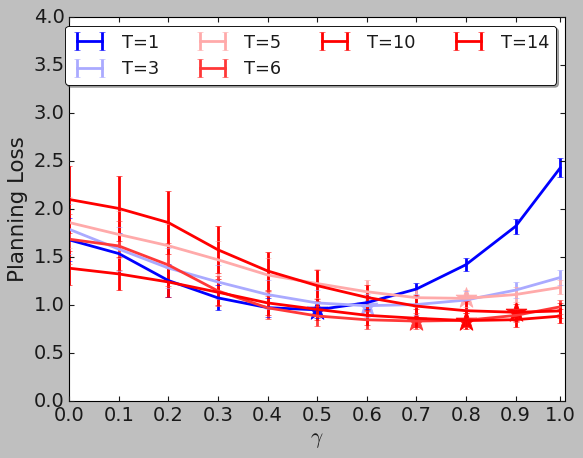

In [ ]:
# @title Paper OMRL Plots

import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

sn.set_context("paper")
sn.set_context("paper", font_scale=2.00)
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['savefig.edgecolor'] = "black"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

nlines=8
c = np.arange(1, nlines + 1)
norm = mpl.colors.Normalize(vmin=c.min()-1, vmax=c.max()+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.bwr)
cmap.set_array([])


def plotloss_paper(y, e, gammas, numtasks):
  fig, ax1 = plt.subplots()
  idx = 0
  gammalist = []
  for i in range(0, numtasks):
    if i==0 or i==2 or i==4 or i==5 or i==9 or i==13:
      yk = y[i,:].reshape((1,y.shape[-1]))
      ek = e[i,:].reshape((1,y.shape[-1]))
      plt.errorbar(gammas, yk[0,:], yerr=(ek[0,:]/(np.sqrt(runs))),
                  label = 'T={}'.format(int(i+1)),
                  color=cmap.to_rgba(idx + i),
                  linewidth=2.5)
      min_x = np.argmin(yk[0,:])
      min_y = np.min(yk[0,:])
      print(min_y, min_x)
      plt.scatter(gammas[min_x], 
                  min_y, 
                  color=cmap.to_rgba(idx + i), 
                  marker='*',
                  s=380)
      plt.ylim((0, 4))   # set the ylim to bottom, top
      plt.xlim((gammas[0], 1))   # set the ylim to bottom, top
      idx += 1
      gammalist.append(gammas[min_x])
  ax1.set_xlabel('$\gamma$')
  ax1.set_ylabel('Planning Loss')
  ax1.set_xticks(gammas)
  plt.legend(bbox_to_anchor=(1, 1), 
             fancybox=True, shadow=True, ncol=4,
             facecolor='w', fontsize=16)
          
  matplotlib.rc('axes', edgecolor='black')
  ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

  # plt.savefig((os.path.join(DIR,"S30m5T20_runs20_randomMDP_averageplanloss_ours_gamma_markers_pruned_1STD"+ ".pdf")), 
  #             dpi=200, orientation='portrait', 
  #             papertype=None, 
  #             format=None,
  #             transparent=True, 
  #             bbox_inches='tight', 
  #             pad_inches=0,
  #             figsize=(4, 4))
  plt.show()
  return fig, gammalist

# planning loss per round t
loss_per_run =  np.zeros((runs, num_tasks, len(gammas)))
err_per_run  =  np.zeros((runs, num_tasks, len(gammas)))
optGamma_run = np.zeros((runs, num_tasks))


# track estimates per round t
var0_gap_run =  np.zeros((runs, num_tasks))
var1_gap_run = np.zeros((runs, num_tasks))
mean0_gap_run =  np.zeros((runs, num_tasks))
mean1_gap_run =  np.zeros((runs, num_tasks))

for i in range(runs):
  loss_per_run[i, :, :] = decoded_A[i][0]
  err_per_run[i, :, :] = decoded_A[i][1]
  optGamma_run[i,:] = decoded_A[i][2] 
  var0_gap_run[i,:] = decoded_A[i][3]
  var1_gap_run[i,:] = decoded_A[i][4]
  mean0_gap_run[i,:] = decoded_A[i][5]
  mean1_gap_run[i,:] = decoded_A[i][6]

avg_loss_per_round = np.mean(loss_per_run, axis=0)
avg_err_per_round = np.mean(err_per_run, axis=0)
std_dev_per_round = np.std(loss_per_run, axis=0)
avg_var0_gap = np.mean(var0_gap_run, axis=0)
avg_var1_gap = np.mean(var1_gap_run, axis=0)
avg_mean0_gap = np.mean(mean0_gap_run, axis=0)
avg_mean1_gap = np.mean(mean1_gap_run, axis=0)

# 1 STD Dev across runs in Errorbars
figomrl_loss, chosen_discount = plotloss_paper(avg_loss_per_round, 
                                               std_dev_per_round,
                                               gammas, num_tasks)

[0.5, 0.7000000000000001, 0.6000000000000001, 0.6000000000000001, 0.8, 0.7000000000000001, 0.7000000000000001, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.8]


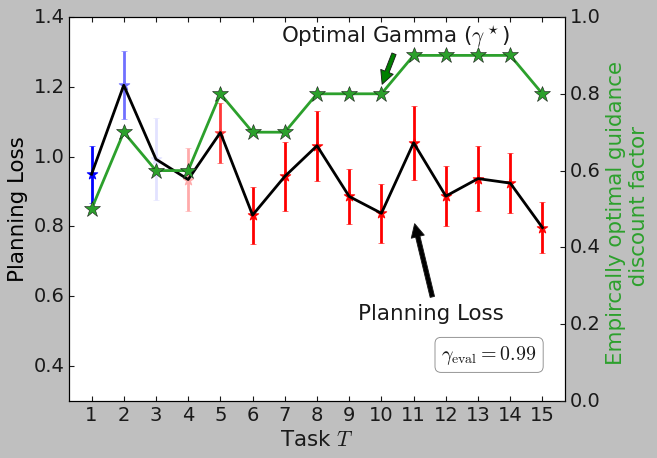

[0.5, 0.7000000000000001, 0.6000000000000001, 0.6000000000000001, 0.8, 0.7000000000000001, 0.7000000000000001, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.8]


In [ ]:
#@title Paper Discount Plots

sn.set_context("paper")
sn.set_context("paper", font_scale=2.00)
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['savefig.edgecolor'] = "black"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


def plotdiscount_paper(y, e, gammas, numtasks): #15*11
  xtoplot = list(range(1, num_tasks+1))
  fig, ax1 = plt.subplots()
  idx = 0
  gammalist = []
  losslist = []
  templist = []
  plt.ylim((0.3, 1.4))   # set the ylim to bottom, top
  #plt.xlim((1, numtasks+1))   # set the ylim to bottom, top
  for i in range(0, numtasks):
    if i>=0:
      yk = y[i,:].reshape((1,y.shape[-1])) #1*11
      ek = e[i,:].reshape((1,y.shape[-1])) #1*11
      min_x = np.argmin(yk[0,:])
      min_y = np.min(yk[0,:])
      plt.scatter(i+1, yk[0,min_x],
                  color=cmap.to_rgba(idx + i),
                  marker='*',
                  s=100)

      # use this for 1-std across runs
      plt.errorbar(i+1, yk[0,min_x], yerr=(ek[0,min_x]/np.sqrt(runs)),
                  color=cmap.to_rgba(idx + i),
                   linewidth=2.5)
      # plt.errorbar(i+1, yk[0,min_x], yerr=ek[0,min_x],
      #             color=cmap.to_rgba(idx + i),
      #              linewidth=2.5)

      idx += 1
      gammalist.append(gammas[min_x])
      losslist.append(min_y)
      templist.append(yk[0,min_x])

  #l1, = plt.plot(xtoplot, gammalist)
  plt.plot(xtoplot, templist, color='black', linewidth=2.5)
  ax1.set_xticks(xtoplot)
  ax1.set_xlabel('Task $T$')
  ax1.set_ylabel('Planning Loss', color ='black')
  
  print(gammalist)
  matplotlib.rc('axes', edgecolor='black')
  # ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

  ax2 = ax1.twinx()
  ax2.set_ylim(0,1)
  l2, = ax2.plot(xtoplot, gammalist, 
                 color="tab:green", 
                 marker='*', 
                 markersize='15',
                 linewidth=2.5)
  ax2.set_ylabel('Empircally optimal guidance \n discount factor', color="tab:green")


  # place a text box in upper left in axes coords
  props = dict(boxstyle='round', facecolor='white', alpha=0.5)
  textstr = ( r'$\gamma_{\mathrm{eval}}=%.2f$ ' % (0.99))
  ax1.text(0.75, 0.15, textstr, transform=ax1.transAxes, 
           fontsize=18, fontweight='bold',
           verticalalignment='top', bbox=props)

  ax1.annotate('Planning Loss ',
            xy=(11, 0.82), xycoords='data',
            xytext=(14, 0.55), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='center')
  
  ax2.annotate('Optimal Gamma ($\gamma^\star$)',
            xy=(10, 0.82), xycoords='data',
            xytext=(14, 0.95), textcoords='data',
            arrowprops=dict(facecolor='green', shrink=0.05),
            horizontalalignment='right', verticalalignment='center')

  # plt.savefig((os.path.join(DIR,"seeds_randomMDP_lossanddiscount_fnoftasks_1STD"+ ".pdf")), 
  #             dpi=200, orientation='portrait', 
  #             papertype=None, 
  #             format=None,
  #             transparent=True, 
  #             bbox_inches='tight', 
  #             pad_inches=0,
  #             figsize=(4, 4))
  plt.show()
  return fig


# plot chosen discount in each round t    
figomrl_discount = plotdiscount_paper(avg_loss_per_round, 
                                      std_dev_per_round,
                                      gammas, num_tasks)

## Adaptation of Planning Horizon - Main script

In [ ]:
# @title Load Saved Data

num_tasks = 15 # @param{"type": "string"}
runs = 100 # @param{"type": "string"}

filename = 'seeds_ours_2022_sacounts_exp_dirich_0PT015_1PT5N_100runs_15tasks_5samples_5trajle.npy' # @param{"type": "string"}
DIR ='/content/drive/My Drive/onlinemetarl_experiments'  # @param{"type": "string"}

gammas = [gamma_ for gamma_ in np.arange(0, 0.99, 0.1)]
gammas.append(0.99)
trueGamma = max(gammas)


fullpath = os.path.join(DIR, filename)
with open(fullpath, 'rb') as f:
  proto = storage_pb2.Data()
  proto.ParseFromString(f.read())
  decoded_A = codec.decode(proto)

loss_per_run =  np.zeros((runs, num_tasks, len(gammas)))
err_per_run  =  np.zeros((runs, num_tasks, len(gammas)))
optGamma_run = np.zeros((runs, num_tasks))

avg_loss_per_round = np.zeros((num_tasks, len(gammas)))
avg_err_per_round = np.zeros((num_tasks, len(gammas)))

for i in range(runs):
  loss_per_run[i, :, :] = decoded_A[i][0]
  err_per_run[i, :, :] = decoded_A[i][1]
  optGamma_run[i,:] = decoded_A[i][2]

avg_loss_per_round = np.mean(loss_per_run, axis=0)
avg_err_per_round = np.mean(err_per_run, axis=0)
std_dev_per_round = np.std(loss_per_run, axis=0)


0.6500936134803411
0.7443411464342337
0.7961107336956521
0.8347071221385196
0.8668515950069346
0.8947558360449406
0.9192335168298524
0.9405545980187217
0.9587523436168399
0.9737572423194897
0.985465282953959
0.9937772978201496
0.9986234360020648
0.9986304496690254


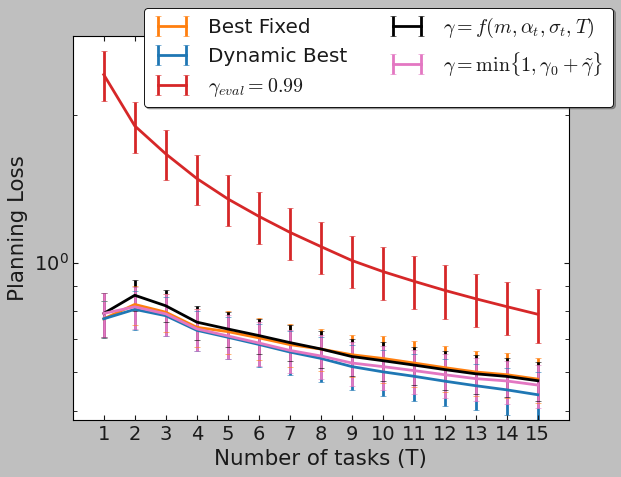

In [ ]:
# @title Latest Plan Loss: Choice of $\gamma$

DIR ='/content/drive/My Drive/onlinemetarl_experiments'  # @param{"type": "string"}
schedule = 1/5
sn.set_context("paper")
sn.set_context("paper", font_scale=2.00)
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['savefig.edgecolor'] = "black"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

m=5
colorslist = ["tab:green", "tab:blue", "tab:red"]

colors = matplotlib.cm.tab20(range(20))

bestinhindsight_loss = np.zeros((num_tasks, 1))
bestinhindsight_err = np.zeros((num_tasks, 1))
bestinhindsight_gamma = np.zeros((num_tasks, 1))

bestvariableinhindsight_loss = np.zeros((num_tasks, 1))
bestvariableinhindsight_err = np.zeros((num_tasks, 1))
bestvariableinhindsight_gamma = np.zeros((num_tasks, 1))

bestasourchedule_loss = np.zeros((num_tasks, 1))
bestasourchedule_err = np.zeros((num_tasks, 1))

best_loss_analytical = np.zeros((num_tasks, 1))
best_err_analytical = np.zeros((num_tasks, 1))

gammaeval_loss = np.zeros((num_tasks, 1))
gammaeval_err = np.zeros((num_tasks, 1))

optGamma_ours_param =  optgamma_ourproposal_alpha(15, m=5,
                                                  sigma_true=0.0129,
                                                  schedule=1/5)

optGamma_Eval = gammas[-1]*np.ones((1, num_tasks))

optGamma_ours_analytical=  optgamma_analytical_fn(num_tasks, m, num_states=10,
                                          sigma=0.0129,
                                          gamma_0=0.35)

for t in range(1,num_tasks+1):
  # ---------------best in hindsight---------------
  # for each gamma, avg planning loss across tasks
  # find the gamma that minimizes this avg planning loss across task
  avgplanloss_overtasks = np.mean(avg_loss_per_round[:t], axis=0, keepdims=True)
  avgplanerr_overtasks = np.mean(avg_err_per_round[:t], axis=0, keepdims=True)
  bestinhindsight_idx = np.argmin(avgplanloss_overtasks[0,:])
  bestinhindsight_loss[t-1,0] = avgplanloss_overtasks[0,bestinhindsight_idx]
  bestinhindsight_err[t-1,0] = avgplanerr_overtasks[0,bestinhindsight_idx]
  bestinhindsight_gamma[t-1,0] = gammas[bestinhindsight_idx]


  # ---------------Best variable discount in hindsight---------------
  # Select the best planning loss across tasks.
  avgplanloss_overgammas_idx = np.argmin(avg_loss_per_round[:t], axis=1)
  bestvariableinhindsight_loss[t-1,0] = np.mean(np.take_along_axis(avg_loss_per_round[:t], 
                                                                   np.expand_dims(avgplanloss_overgammas_idx, axis=-1), axis=1), axis=0)
  bestvariableinhindsight_err[t-1,0] = np.mean(np.take_along_axis(avg_err_per_round[:t], 
                                                                   np.expand_dims(avgplanloss_overgammas_idx, axis=-1), axis=1), axis=0)
  bestvariableinhindsight_gamma[t-1,0] = gammas[avgplanloss_overgammas_idx[t-1]]



  # # ---------------Our schedule of gamma---------------
  loss_per_round_ours = np.zeros((t,1))
  err_per_round_ours = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_param[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_ours[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_ours[i,0] = avg_err_per_round[i,equivalent_gamma_idx]

  bestasourchedule_loss[t-1,0] = np.mean(loss_per_round_ours, axis=0, keepdims=True)
  bestasourchedule_err[t-1,0] = np.mean(err_per_round_ours, axis=0, keepdims=True)


  # # ---------------Gamma Eval Schedule---------------
  loss_per_round_eval = np.zeros((t,1))
  err_per_round_eval  = np.zeros((t,1))

  for i, ival in enumerate(optGamma_Eval[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_eval[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_eval[i,0] = avg_err_per_round[i,equivalent_gamma_idx]

  gammaeval_loss[t-1,0] = np.mean(loss_per_round_eval, axis=0, keepdims=True)
  gammaeval_err[t-1,0] = np.mean(err_per_round_eval, axis=0, keepdims=True)



  # # ---------------Gamma Analytical Schedule---------------
  loss_per_round_analytical = np.zeros((t,1))
  err_per_round_analytical  = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_analytical[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_analytical[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_analytical[i,0] = avg_err_per_round[i,equivalent_gamma_idx]

  best_loss_analytical[t-1,0] = np.mean(loss_per_round_analytical, axis=0, keepdims=True)
  best_err_analytical[t-1,0] = np.mean(err_per_round_analytical, axis=0, keepdims=True)


#--------------------------------------------------------#
# plotting the planning loss baselines 
fig, ax1 = plt.subplots()
xtoplot = list(range(1, num_tasks+1))
ax1.set_yscale('log')
plt.ylim((0.48, 2.9))   # set the ylim to bottom, top
# plt.ylim((0.47, 1.1))   # set the ylim to bottom, top #zoomed 

plt.errorbar(xtoplot,
             bestinhindsight_loss,
             bestinhindsight_err[:,0], 
             label='Best Fixed',
             color = "tab:orange",
             linewidth=2.5)

plt.errorbar(xtoplot,
             bestvariableinhindsight_loss,
             bestvariableinhindsight_err[:,0], 
             label='Dynamic Best',
             color = "tab:blue",
             linewidth=2.5)

plt.errorbar(xtoplot,
             gammaeval_loss,
             gammaeval_err[:,0], 
             label='$\gamma_{eval}=0.99$',
             color = "tab:red",
             linewidth=2.5,)

plt.errorbar(xtoplot,
             bestasourchedule_loss,
             bestasourchedule_err[:,0], 
             label=r'$\gamma=f({m,\alpha_{t}, \sigma_{t}, T})$ ',
             color = "black",
             linewidth=2.5)

plt.errorbar(xtoplot,
             best_loss_analytical,
             best_err_analytical[:,0], 
             label= r'$\gamma=\min\{1,\gamma_0+\tilde\gamma\}$ ',
             color = 'tab:pink',
             linewidth=2.5)


ax1.set_xlabel('Number of tasks (T)')
ax1.set_ylabel('Planning Loss')
ax1.set_xticks(xtoplot)

plt.legend(bbox_to_anchor=(1.11, 1.1), fancybox=True, shadow=True, ncol=2,
          facecolor='w', fontsize=18)
          
matplotlib.rc('axes', edgecolor='black')

# plt.savefig((os.path.join(DIR,"lossforgammaschedules_600runs_usingstdbysqrtruns"+ ".pdf")), 
#             dpi=200, orientation='portrait', 
#             papertype=None, 
#             format=None,
#             transparent=True, 
#             bbox_inches='tight', 
#             pad_inches=0,
#             figsize=(4, 4))
plt.show()


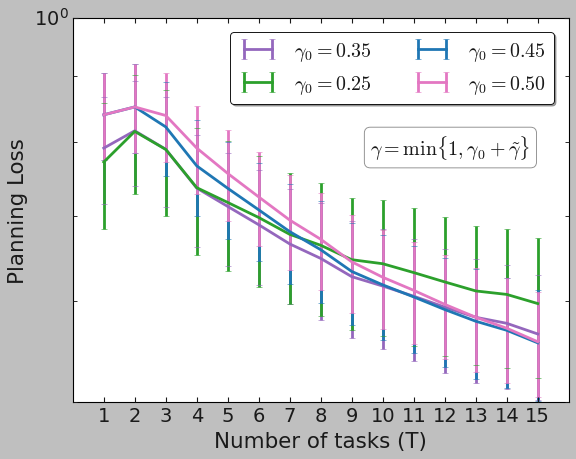

In [ ]:
# @title Ours for different $\gamma_0$

DIR ='/content/drive/My Drive/onlinemetarl_experiments'  # @param{"type": "string"}
schedule = 1/5
sn.set_context("paper")
sn.set_context("paper", font_scale=2.00)
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['savefig.edgecolor'] = "black"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


m=5
colorslist = ["tab:green", "tab:blue", "tab:red"]



gammaeval_loss = np.zeros((num_tasks, 1))
gammaeval_err = np.zeros((num_tasks, 1))


optGamma_Eval = gammas[-1]*np.ones((1, num_tasks))

optGamma_ours_analytical_1 =  optgamma_analytical_fn(num_tasks, m, num_states=10,
                                          sigma=0.0129,
                                          gamma_0=0.35)
best_loss_analytical_1 = np.zeros((num_tasks, 1))
best_err_analytical_1 = np.zeros((num_tasks, 1))



optGamma_ours_analytical_2 =  optgamma_analytical_fn(num_tasks, m, num_states=10,
                                          sigma=0.0129,
                                          gamma_0=0.25)
best_loss_analytical_2 = np.zeros((num_tasks, 1))
best_err_analytical_2 = np.zeros((num_tasks, 1))


optGamma_ours_analytical_3 =  optgamma_analytical_fn(num_tasks, m, num_states=10,
                                          sigma=0.0129,
                                          gamma_0=0.45)
best_loss_analytical_3 = np.zeros((num_tasks, 1))
best_err_analytical_3 = np.zeros((num_tasks, 1))


optGamma_ours_analytical_4 =  optgamma_analytical_fn(num_tasks, m, num_states=10,
                                          sigma=0.0129,
                                          gamma_0=0.50)
best_loss_analytical_4 = np.zeros((num_tasks, 1))
best_err_analytical_4 = np.zeros((num_tasks, 1))


for t in range(1,num_tasks+1):
  # # ---------------Gamma Eval Schedule---------------
  loss_per_round_eval = np.zeros((t,1))
  err_per_round_eval  = np.zeros((t,1))

  for i, ival in enumerate(optGamma_Eval[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_eval[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_eval[i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  gammaeval_loss[t-1,0] = np.mean(loss_per_round_eval, axis=0, keepdims=True)
  gammaeval_err[t-1,0] = np.mean(err_per_round_eval, axis=0, keepdims=True)



  # # ---------------Gamma Analytical Schedule---------------
  loss_per_round_analytical_1 = np.zeros((t,1))
  err_per_round_analytical_1   = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_analytical_1[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_analytical_1 [i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_analytical_1 [i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  best_loss_analytical_1 [t-1,0] = np.mean(loss_per_round_analytical_1 , axis=0, keepdims=True)
  best_err_analytical_1 [t-1,0] = np.mean(err_per_round_analytical_1 , axis=0, keepdims=True)


 # # ---------------Gamma Analytical Schedule---------------
  loss_per_round_analytical_2 = np.zeros((t,1))
  err_per_round_analytical_2   = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_analytical_2[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_analytical_2 [i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_analytical_2 [i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  best_loss_analytical_2 [t-1,0] = np.mean(loss_per_round_analytical_2 , axis=0, keepdims=True)
  best_err_analytical_2 [t-1,0] = np.mean(err_per_round_analytical_2 , axis=0, keepdims=True)


  # # ---------------Gamma Analytical Schedule---------------
  loss_per_round_analytical_3 = np.zeros((t,1))
  err_per_round_analytical_3  = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_analytical_3[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_analytical_3 [i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_analytical_3 [i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  best_loss_analytical_3 [t-1,0] = np.mean(loss_per_round_analytical_3 , axis=0, keepdims=True)
  best_err_analytical_3 [t-1,0] = np.mean(err_per_round_analytical_3 , axis=0, keepdims=True)



  # # ---------------Gamma Analytical Schedule---------------
  loss_per_round_analytical_4 = np.zeros((t,1))
  err_per_round_analytical_4  = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_analytical_4[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_analytical_4[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_analytical_4[i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  best_loss_analytical_4 [t-1,0] = np.mean(loss_per_round_analytical_4 , axis=0, keepdims=True)
  best_err_analytical_4 [t-1,0] = np.mean(err_per_round_analytical_4 , axis=0, keepdims=True)


#--------------------------------------------------------#
# plotting the planning loss baselines 
fig, ax1 = plt.subplots()
xtoplot = list(range(1, num_tasks+1))
ax1.set_yscale('log')
plt.ylim((0.5, 1))   # set the ylim to bottom, top # use this for analytical

plt.errorbar(xtoplot,
             best_loss_analytical_1,
             #(1.96*best_err_analytical_1[:,0])/np.sqrt(runs),
             (best_err_analytical_1[:,0])/np.sqrt(runs), 
             label='$\gamma_0=0.35$',
             color = 'tab:purple',
             linewidth=2.5)

plt.errorbar(xtoplot,
             best_loss_analytical_2,
             #(1.96*best_err_analytical_2[:,0])/np.sqrt(runs), 
             (best_err_analytical_2[:,0])/np.sqrt(runs), 
             label='$\gamma_0=0.25$',
             color = 'tab:green',
             linewidth=2.5)


plt.errorbar(xtoplot,
             best_loss_analytical_3,
             #(1.96*best_err_analytical_3[:,0])/np.sqrt(runs), 
             (best_err_analytical_3[:,0])/np.sqrt(runs), 
             label='$\gamma_0=0.45$',
             color = 'tab:blue',
             linewidth=2.5)

plt.errorbar(xtoplot,
             best_loss_analytical_4,
             #(1.96*best_err_analytical_4[:,0])/np.sqrt(runs), 
             (best_err_analytical_4[:,0])/np.sqrt(runs), 
             label='$\gamma_0=0.50$',
             color = 'tab:pink',
             linewidth=2.5)

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = ( r'$\gamma=\min\{1,\gamma_0+\tilde\gamma\}$') 
ax1.text(0.6, 0.7, textstr, transform=ax1.transAxes, 
          fontsize=18, fontweight='bold',
          verticalalignment='top', bbox=props)


ax1.set_xlabel('Number of tasks (T)')
ax1.set_ylabel('Planning Loss')
ax1.set_xticks(xtoplot)
plt.legend(bbox_to_anchor=(0.99, 0.99), fancybox=True, shadow=True, ncol=2,
          facecolor='w', fontsize=18)
          
matplotlib.rc('axes', edgecolor='black')

# plt.savefig((os.path.join(DIR,"various_gamma0_600runs_usingstdbysqrtruns"+ ".pdf")), 
#             dpi=200, orientation='portrait', 
#             papertype=None, 
#             format=None,
#             transparent=True, 
#             bbox_inches='tight', 
#             pad_inches=0,
#             figsize=(4, 4))
plt.show()


0.6500936134803411
0.7443411464342337
0.7961107336956521
0.8347071221385196
0.8668515950069346
0.8947558360449406
0.9192335168298524
0.9405545980187217
0.9587523436168399
0.9737572423194897
0.985465282953959
0.9937772978201496
0.9986234360020648
0.9986304496690254


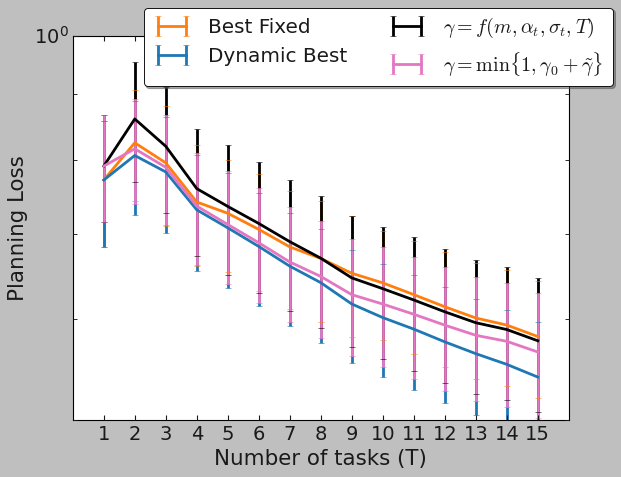

In [ ]:
# @title Latest Plan Loss: Choice of $\gamma$ 1-STD

DIR ='/content/drive/My Drive/onlinemetarl_experiments'  # @param{"type": "string"}
schedule = 1/5
sn.set_context("paper")
sn.set_context("paper", font_scale=2.00)
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['savefig.edgecolor'] = "black"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

m=5
colorslist = ["tab:green", "tab:blue", "tab:red"]

colors = matplotlib.cm.tab20(range(20))

#std_dev_per_round holds tasks*gammas std dev across all runs.

bestinhindsight_loss = np.zeros((num_tasks, 1))
bestinhindsight_std = np.zeros((num_tasks, 1))

bestinhindsight_gamma = np.zeros((num_tasks, 1))

bestvariableinhindsight_loss = np.zeros((num_tasks, 1))
bestvariableinhindsight_std = np.zeros((num_tasks, 1))
bestvariableinhindsight_gamma = np.zeros((num_tasks, 1))

bestasperben_loss = np.zeros((num_tasks, 1))
bestasperben_std = np.zeros((num_tasks, 1))

bestasourchedule_loss = np.zeros((num_tasks, 1))
bestasourchedule_std = np.zeros((num_tasks, 1))

best_loss_analytical = np.zeros((num_tasks, 1))
best_std_analytical = np.zeros((num_tasks, 1))

gammaeval_loss = np.zeros((num_tasks, 1))
gammaeval_std = np.zeros((num_tasks, 1))


optGamma_ours_param =  optgamma_ourproposal_alpha(15, m=5,
                                                  sigma_true=0.0129,
                                                  schedule=1/5)

optGamma_Eval = gammas[-1]*np.ones((1, num_tasks))

optGamma_ours_analytical=  optgamma_analytical_fn(num_tasks, m, num_states=10,
                                          sigma=0.0129,
                                          gamma_0=0.35)

for t in range(1,num_tasks+1):
  # ---------------best in hindsight---------------
  # for each gamma, avg planning loss across tasks
  # find the gamma that minimizes this avg planning loss across task
  avgplanloss_overtasks = np.mean(avg_loss_per_round[:t], axis=0, keepdims=True)
  avgplanerr_overtasks = np.mean(std_dev_per_round[:t], axis=0, keepdims=True)
  bestinhindsight_idx = np.argmin(avgplanloss_overtasks[0,:])
  bestinhindsight_loss[t-1,0] = avgplanloss_overtasks[0,bestinhindsight_idx]
  bestinhindsight_std[t-1,0] = avgplanerr_overtasks[0,bestinhindsight_idx]
  bestinhindsight_gamma[t-1,0] = gammas[bestinhindsight_idx]


  # ---------------Best variable discount in hindsight---------------
  # Select the best planning loss across tasks.
  avgplanloss_overgammas_idx = np.argmin(avg_loss_per_round[:t], axis=1)
  bestvariableinhindsight_loss[t-1,0] = np.mean(np.take_along_axis(avg_loss_per_round[:t], 
                                                                   np.expand_dims(avgplanloss_overgammas_idx, axis=-1), axis=1), axis=0)
  bestvariableinhindsight_std[t-1,0] = np.mean(np.take_along_axis(std_dev_per_round[:t], 
                                                                   np.expand_dims(avgplanloss_overgammas_idx, axis=-1), axis=1), axis=0)
  bestvariableinhindsight_gamma[t-1,0] = gammas[avgplanloss_overgammas_idx[t-1]]


  # # ---------------Our schedule of gamma---------------
  loss_per_round_ours = np.zeros((t,1))
  err_per_round_ours = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_param[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_ours[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_ours[i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  bestasourchedule_loss[t-1,0] = np.mean(loss_per_round_ours, axis=0, keepdims=True)
  bestasourchedule_std[t-1,0] = np.mean(err_per_round_ours, axis=0, keepdims=True)


  # # ---------------Gamma Eval Schedule---------------
  loss_per_round_eval = np.zeros((t,1))
  err_per_round_eval  = np.zeros((t,1))

  for i, ival in enumerate(optGamma_Eval[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_eval[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_eval[i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  gammaeval_loss[t-1,0] = np.mean(loss_per_round_eval, axis=0, keepdims=True)
  gammaeval_std[t-1,0] = np.mean(err_per_round_eval, axis=0, keepdims=True)



  # # ---------------Gamma Analytical Schedule---------------
  loss_per_round_analytical = np.zeros((t,1))
  err_per_round_analytical  = np.zeros((t,1))

  for i, ival in enumerate(optGamma_ours_analytical[0,:t]):
    equivalent_gamma_idx = -1
    mindiff = 100
    for j, jval in enumerate(gammas):
      diff = np.abs(ival-jval) 
      if diff < mindiff:
        mindiff = diff
        equivalent_gamma_idx = j
        
    loss_per_round_analytical[i,0] = avg_loss_per_round[i,equivalent_gamma_idx]
    err_per_round_analytical[i,0] = std_dev_per_round[i,equivalent_gamma_idx]

  best_loss_analytical[t-1,0] = np.mean(loss_per_round_analytical, axis=0, keepdims=True)
  best_std_analytical[t-1,0] = np.mean(err_per_round_analytical, axis=0, keepdims=True)


#--------------------------------------------------------#
# plotting the planning loss baselines 
fig, ax1 = plt.subplots()
xtoplot = list(range(1, num_tasks+1))
ax1.set_yscale('log')
#plt.ylim((0.52, 2.9))
plt.ylim((0.5, 1.0))   # set the ylim to bottom, top #zoomed 

plt.errorbar(xtoplot,
             bestinhindsight_loss,
             #(1.96*bestinhindsight_std[:,0])/np.sqrt(runs),
             (bestinhindsight_std[:,0])/np.sqrt(runs), 
             label='Best Fixed',
             color = "tab:orange",
             linewidth=2.5)

plt.errorbar(xtoplot,
             bestvariableinhindsight_loss,
             #(1.96*bestvariableinhindsight_std[:,0])/np.sqrt(runs),
             (bestvariableinhindsight_std[:,0])/np.sqrt(runs), 
             label='Dynamic Best',
             color = "tab:blue",
             linewidth=2.5)

plt.errorbar(xtoplot,
             bestasourchedule_loss,
             #(1.96*bestasourchedule_std[:,0])/np.sqrt(runs), 
             (bestasourchedule_std[:,0])/np.sqrt(runs), 
             label=r'$\gamma=f({m,\alpha_{t}, \sigma_{t}, T})$ ',
             color = "black",
             linewidth=2.5)

plt.errorbar(xtoplot,
             best_loss_analytical,
             #(1.96*best_std_analytical[:,0])/np.sqrt(runs),
             (best_std_analytical[:,0])/np.sqrt(runs), 
             label= r'$\gamma=\min\{1,\gamma_0+\tilde\gamma\}$ ',
             color = 'tab:pink',
             linewidth=2.5)


ax1.set_xlabel('Number of tasks (T)')
ax1.set_ylabel('Planning Loss')
ax1.set_xticks(xtoplot)
plt.legend(bbox_to_anchor=(1.11, 1.1), fancybox=True, shadow=True, ncol=2,
          facecolor='w', fontsize=18)
          
matplotlib.rc('axes', edgecolor='black')

# plt.savefig((os.path.join(DIR,"lossforgammaschedules_600runs_zoomed_usingstdbysqrtruns"+ ".pdf")), 
#             dpi=200, orientation='portrait', 
#             papertype=None, 
#             format=None,
#             transparent=True, 
#             bbox_inches='tight', 
#             pad_inches=0,
#             figsize=(4, 4))
# plt.show()


# Run Different Baselines - Save and Compile Results


In [ ]:
# @title  Baseline Methods.
def compute_optimal_alpha(sigma0_1, sigma0_2, samples_):
  '''
  alpha* =  \frac{1}{\sigma^2_o * m + 1}
  '''

  alpha1 = 0.01*np.ones((sigma0_1.shape[0], 1))
  alpha2 = 0.01*np.ones((sigma0_2.shape[0], 1))

  for i in range(sigma0_1.shape[0]):
    sigma0_1_square = np.square(np.max(sigma0_1[i, :]))
    sigma0_2_square = np.square(np.max(sigma0_2[i, :]))
    alpha1[i,0] = 1/(np.multiply(sigma0_1_square, samples_) + 1)   
    alpha2[i,0] = 1/(np.multiply(sigma0_2_square, samples_) + 1)   

  assert np.all((alpha1 >=0) & (alpha1 <=1) )
  assert np.all((alpha2 >=0) & (alpha2 <=1) )

  return alpha1, alpha2





def update_alpha_knownsigma(sigma0_1, sigma0_2, samples_,
                            v2, roundt):
  '''
  alpha_t =  \frac{v^2}{\sigma^2_o * (1+1/t) * m + v^2}
  '''

  alpha1_t = 0.01*np.ones((sigma0_1.shape[0], 1))
  alpha2_t = 0.01*np.ones((sigma0_2.shape[0], 1))

  for i in range(sigma0_1.shape[0]):
    alpha1_t[i,0] = v2/(np.multiply(np.multiply(np.max(sigma0_1[i, :]), (1+1/roundt)), samples_) + v2)   #make v2 smaller, and add (1-1/np.sqrt(roundt)) as a correction term multiplier.
    alpha2_t[i,0] = v2/(np.multiply(np.multiply(np.max(sigma0_2[i, :]), (1+1/roundt)), samples_) + v2) 

  assert np.all((alpha1_t >=0) & (alpha1_t <=1) )
  assert np.all((alpha2_t >=0) & (alpha2_t <=1) )

  return alpha1_t, alpha2_t


def experiment_omrl_lowerboundknownsigma(num_tasks, gammas, num_states, k, samples_, trials,
                               trueGamma, v2, max_trajectory_length,
                               seed_in):
  # planning loss per round t
  loss_per_round =  np.zeros((num_tasks, len(gammas)))
  err_per_round  =  np.zeros((num_tasks, len(gammas)))
  optGamma_round = np.zeros((1, num_tasks))
  var0_gap_per_round = np.zeros((1, num_tasks))
  var1_gap_per_round = np.zeros((1, num_tasks))
  mean0_gap_per_round = np.zeros((1, num_tasks))
  mean1_gap_per_round = np.zeros((1, num_tasks))


  # initialize alpha
  alpha1_t = 0.0 * np.ones((num_states,1))
  alpha2_t = 0.0 * np.ones((num_states,1))
  alpha_t = [alpha1_t, alpha2_t]

  #Run specific seed
  np.random.seed(seed_in)

  # Generate prior distribution from randomMDP
  P1_Prior, R1 = randomMDP(num_states, k)
  P2_Prior, R2 = randomMDP(num_states, k)

  sigma0_1 = np.zeros((num_states, num_states))
  sigma0_2 = np.zeros((num_states, num_states))

  # define the dirichlet prior distribution
  # todo: try different, 1.5/2 and 1.5/4 and the expectation is u will not decrease too fast
  # more or less look similar. # alpha* will not increase too much. 
  alphasdirich1 = (P1_Prior + 0.015)*1.5*num_states
  alphasdirich2 = (P2_Prior + 0.015)*1.5*num_states

  # ground truth variance of prior distribution
  for i in range(0, num_states):
    z = np.sum(alphasdirich1[i,:])
    sigma0_1[i,:] = np.multiply(alphasdirich1[i,:]/z, (1-alphasdirich1[i,:]/z))
    sigma0_1[i,:] = sigma0_1[i,:]/(z+1)

    z = np.sum(alphasdirich2[i,:])
    sigma0_2[i,:] = np.multiply(alphasdirich2[i,:]/z, (1-alphasdirich2[i,:]/z))
    sigma0_2[i,:] = sigma0_2[i,:]/(z+1)


  # set meta-initialize P_o_hat, sigma_o_hat, alpha_t > 0
  # the learner knows the true mean Po - centre of task ball.
  P1ohat_t = P1_Prior
  P2ohat_t = P2_Prior

  # the learner knows the true variance of the task ball.
  sigmao1hat_t = sigma0_1
  sigmao2hat_t = sigma0_2

  for roundt in range(1, num_tasks+1):
      # sample a Pt ~ task dist. for round t
      Pt_1 = np.zeros((num_states, num_states))
      Pt_2 = np.zeros((num_states, num_states))  
      for i in range(0, num_states):
        Pt_1[i,:] = np.random.dirichlet(alphasdirich1[i,:])
        Pt_2[i,:] = np.random.dirichlet(alphasdirich2[i,:])
      _unit_test_P(Pt_1)
      _unit_test_P(Pt_2) 
      
      # generate a batch of data and process to compute planning loss
      loss_t, err_t = processwithintask(Pt_1, R1, Pt_2, R2, samples_, 
                                    gammas, trueGamma, trials,
                                    alpha=alpha_t, P1o=P1ohat_t,
                                    P2o=P2ohat_t)
                                    
      idx = np.argmin(loss_t)
      optGamma_round[0, roundt-1] = gammas[idx]

      loss_per_round[roundt-1, :] = loss_t
      err_per_round[roundt-1, :] = err_t

      
      alpha1_tp1, alpha2_tp1 = update_alpha_knownsigma(sigma0_1, sigma0_2,
                                                       samples_, v2,
                                                       roundt)
      alpha1_t = alpha1_tp1
      alpha2_t = alpha2_tp1
      alpha_t = [alpha1_t, alpha2_t]    

      if roundt==1:
        continue

      var0_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_1-sigmao1hat_t, ord=2)
      var1_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_2-sigmao2hat_t, ord=2)
      mean0_gap_per_round[0, roundt-1] = np.linalg.norm(P1_Prior-P1ohat_t, ord=2)
      mean1_gap_per_round[0, roundt-1] = np.linalg.norm(P2_Prior-P2ohat_t, ord=2)

  return loss_per_round, err_per_round, optGamma_round, var0_gap_per_round, var1_gap_per_round, mean0_gap_per_round, mean1_gap_per_round

def experiment_omrl_lowerbound(num_tasks, gammas, num_states, k, samples_, trials,
                               trueGamma, v2, max_trajectory_length,
                               seed_in):
  # planning loss per round t
  loss_per_round =  np.zeros((num_tasks, len(gammas)))
  err_per_round  =  np.zeros((num_tasks, len(gammas)))
  optGamma_round = np.zeros((1, num_tasks))
  var0_gap_per_round = np.zeros((1, num_tasks))
  var1_gap_per_round = np.zeros((1, num_tasks))
  mean0_gap_per_round = np.zeros((1, num_tasks))
  mean1_gap_per_round = np.zeros((1, num_tasks))


  # initialize alpha
  alpha1_t = 0.0 * np.ones((num_states,1))
  alpha2_t = 0.0 * np.ones((num_states,1))
  alpha_t = [alpha1_t, alpha2_t]

  #Run specific seed
  np.random.seed(seed_in)

  # Generate prior distribution from randomMDP
  P1_Prior, R1 = randomMDP(num_states, k)
  P2_Prior, R2 = randomMDP(num_states, k)

  sigma0_1 = np.zeros((num_states, num_states))
  sigma0_2 = np.zeros((num_states, num_states))

  # define the dirichlet prior distribution
  alphasdirich1 = (P1_Prior + 0.015)*1.5*num_states
  alphasdirich2 = (P2_Prior + 0.015)*1.5*num_states

  # ground truth variance of prior distribution
  for i in range(0, num_states):
    z = np.sum(alphasdirich1[i,:])
    sigma0_1[i,:] = np.multiply(alphasdirich1[i,:]/z, (1-alphasdirich1[i,:]/z))
    sigma0_1[i,:] = sigma0_1[i,:]/(z+1)

    z = np.sum(alphasdirich2[i,:])
    sigma0_2[i,:] = np.multiply(alphasdirich2[i,:]/z, (1-alphasdirich2[i,:]/z))
    sigma0_2[i,:] = sigma0_2[i,:]/(z+1)

  # set meta-initialize P_o_hat, sigma_o_hat, alpha_t > 0
  # the learner knows the true mean Po - centre of task ball.
  P1ohat_t = P1_Prior
  P2ohat_t = P2_Prior

  # the learner knows the true variance of the task ball.
  sigmao1hat_t = sigma0_1
  sigmao2hat_t = sigma0_2

  # the learner knows the optimal alpha parameter.
  alpha1_t, alpha2_t = compute_optimal_alpha(sigmao1hat_t, 
                                             sigmao2hat_t, 
                                             samples_)
  
  alpha_t = [alpha1_t, alpha2_t]

  for roundt in range(1, num_tasks+1):
      # sample a Pt ~ task dist. for round t
      Pt_1 = np.zeros((num_states, num_states))
      Pt_2 = np.zeros((num_states, num_states))  
      for i in range(0, num_states):
        Pt_1[i,:] = np.random.dirichlet(alphasdirich1[i,:])
        Pt_2[i,:] = np.random.dirichlet(alphasdirich2[i,:])
      _unit_test_P(Pt_1)
      _unit_test_P(Pt_2) 
      
      # generate a batch of data and process to compute planning loss
      loss_t, err_t = processwithintask(Pt_1, R1, Pt_2, R2, samples_, 
                                    gammas, trueGamma, trials,
                                    alpha=alpha_t, P1o=P1ohat_t,
                                    P2o=P2ohat_t)
                                    
      idx = np.argmin(loss_t)
      optGamma_round[0, roundt-1] = gammas[idx]

      loss_per_round[roundt-1, :] = loss_t
      err_per_round[roundt-1, :] = err_t
    

      if roundt==1:
        continue

      var0_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_1-sigmao1hat_t, ord=2)
      var1_gap_per_round[0, roundt-1] = np.linalg.norm(sigma0_2-sigmao2hat_t, ord=2)
      mean0_gap_per_round[0, roundt-1] = np.linalg.norm(P1_Prior-P1ohat_t, ord=2)
      mean1_gap_per_round[0, roundt-1] = np.linalg.norm(P2_Prior-P2ohat_t, ord=2)

  return loss_per_round, err_per_round, optGamma_round, var0_gap_per_round, var1_gap_per_round, mean0_gap_per_round, mean1_gap_per_round



def experiment_without_metalearning(num_tasks, gammas, num_states, k, samples_, trials,
                                    trueGamma, v2, max_trajectory_length,
                                    seed_in):
  # planning loss per round t
  loss_per_round =  np.zeros((num_tasks, len(gammas)))
  err_per_round  =  np.zeros((num_tasks, len(gammas)))
  optGamma_round = np.zeros((1, num_tasks))

  #Run specific seed
  np.random.seed(seed_in)
 
  # Generate prior distribution from randomMDP
  P1_Prior, R1 = randomMDP(num_states, k)
  P2_Prior, R2 = randomMDP(num_states, k)

  sigma0_1 = np.zeros((num_states, num_states))
  sigma0_2 = np.zeros((num_states, num_states))

  # define the dirichlet prior distribution
  alphasdirich1 = (P1_Prior + 0.015)*1.5*num_states
  alphasdirich2 = (P2_Prior + 0.015)*1.5*num_states

  # ground truth variance of prior distribution
  for i in range(0, num_states):
    z = np.sum(alphasdirich1[i,:])
    sigma0_1[i,:] = np.multiply(alphasdirich1[i,:]/z, (1-alphasdirich1[i,:]/z))
    sigma0_1[i,:] = sigma0_1[i,:]/(z+1)

    z = np.sum(alphasdirich2[i,:])
    sigma0_2[i,:] = np.multiply(alphasdirich2[i,:]/z, (1-alphasdirich2[i,:]/z))
    sigma0_2[i,:] = sigma0_2[i,:]/(z+1)

  for roundt in range(1, num_tasks+1):
      # sample a Pt ~ task dist. for round t
      Pt_1 = np.zeros((num_states, num_states))
      Pt_2 = np.zeros((num_states, num_states))  
      for i in range(0, num_states):
        Pt_1[i,:] = np.random.dirichlet(alphasdirich1[i,:])
        Pt_2[i,:] = np.random.dirichlet(alphasdirich2[i,:])
      _unit_test_P(Pt_1)
      _unit_test_P(Pt_2) 
      
      # generate a batch of data and process to compute planning loss
      loss_t, err_t = processwithintask(Pt_1, R1, Pt_2, R2, samples_,
                                        gammas, trueGamma, trials)
                                    
      idx = np.argmin(loss_t)
      optGamma_round[0, roundt-1] = gammas[idx]

      loss_per_round[roundt-1, :] = loss_t
      err_per_round[roundt-1, :] = err_t

  return loss_per_round, err_per_round, optGamma_round

In [ ]:
# @title Launch Runs - Baseline
seed = 88

samples_ = 5
num_tasks = 15
num_states = 10
max_trajectory_length = 5
k = 5
v2 = 1/4
gammas = [gamma_ for gamma_ in np.arange(0, 0.99, 0.1)]
gammas.append(0.99)
trueGamma = max(gammas)
runs = 50
trials = 100


iterables = []
for run_id in range(runs):
  iterables.append([num_tasks, gammas, num_states, k, samples_, 
                            trials, trueGamma, v2, max_trajectory_length, seed+run_id])



%timeit

# Baseline I - Known Po, sigmao and alpha*
# A = pmap(experiment_omrl_lowerbound, iterables, nproc=8)


# Baseline II - Without meta-learning.
A = pmap(experiment_without_metalearning, iterables, nproc=8)


# Baseline - Known Po, Known sigmao and alpha = f(known sigma, t)
# A = pmap(experiment_omrl_lowerboundknownsigma, iterables, nproc=8)



In [ ]:
# @title  Save Data, Compile Runs


filename = '2022_sacounts_exp_dirich_0PT015BY4_1PT5N_100runs_15tasks_5samples_5trajle.npy' # @param{"type": "string"}
DIR ='/content/drive/My Drive/onlinemetarl_experiments/'  # @param{"type": "string"}
fullpath = DIR + filename

#----------------START --> Use to load only -----------#

num_tasks = 15 # @param{"type": "string"}
runs = 100 # @param{"type": "string"}


gammas = [gamma_ for gamma_ in np.arange(0, 0.99, 0.1)]
gammas.append(0.99)
trueGamma = max(gammas)


fullpath = os.path.join(DIR, filename)
with open(fullpath, 'rb') as f:
  proto = storage_pb2.Data()
  proto.ParseFromString(f.read())
  decoded_A = codec.decode(proto)
#----------------END ---------------------------------#

loss_per_run =  np.zeros((runs, num_tasks, len(gammas)))
err_per_run  =  np.zeros((runs, num_tasks, len(gammas)))
optGamma_run = np.zeros((runs, num_tasks))

avg_loss_per_round = np.zeros((num_tasks, len(gammas)))
avg_err_per_round = np.zeros((num_tasks, len(gammas)))
std_dev_per_round = np.zeros((num_tasks, len(gammas)))

for i in range(runs):
  loss_per_run[i, :, :] = decoded_A[i][0]
  err_per_run[i, :, :] = decoded_A[i][1]
  optGamma_run[i,:] = decoded_A[i][2]

avg_loss_per_round = np.mean(loss_per_run, axis=0)
avg_err_per_round = np.mean(err_per_run, axis=0)
std_dev_per_round = np.std(loss_per_run, axis=0) # standard deviation across runs.

0.949638347757141 5
1.2045159018301461 7
0.9926812590884482 6
1.0690266251983802 8
0.8325349898365892 7
0.8858695988168768 8
0.9241748117251446 9
0.7966320794113655 8


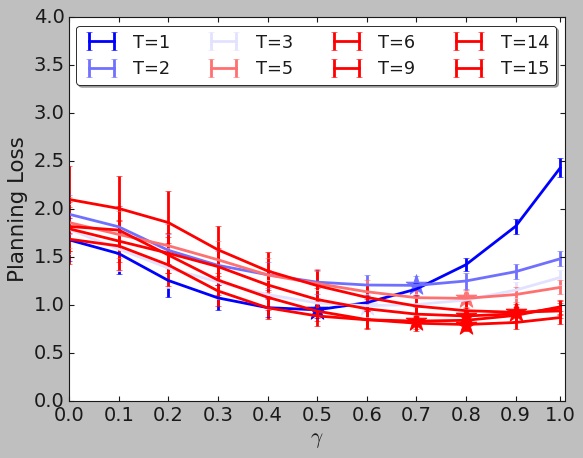

In [ ]:
# @title Paper OMRL Baseline Plots


import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

sn.set_context("paper")
sn.set_context("paper", font_scale=2.00)
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['savefig.edgecolor'] = "black"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


nlines=8
c = np.arange(1, nlines + 1)
norm = mpl.colors.Normalize(vmin=c.min()-1, vmax=c.max()+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.bwr)
cmap.set_array([])


def plotloss_paper(y, e, gammas, numtasks):
  fig, ax1 = plt.subplots()
  idx = 0
  gammalist = []
  for i in range(0, numtasks):
    if i==0 or i==1 or i==2 or i==4 or i==5 or i==8 or i>=13:  
      yk = y[i,:].reshape((1,y.shape[-1]))
      ek = e[i,:].reshape((1,y.shape[-1]))
      # Use this for 1-STD std_dev_per_round
      plt.errorbar(gammas, yk[0,:], yerr=(ek[0,:]/np.sqrt(runs)),
                  label = 'T={}'.format(int(i+1)),
                  color=cmap.to_rgba(idx + i),
                   linewidth=2.5)
      min_x = np.argmin(yk[0,:])
      min_y = np.min(yk[0,:])
      print(min_y, min_x)
      plt.scatter(gammas[min_x], min_y, 
                  color=cmap.to_rgba(idx + i), 
                  marker='*',
                  s=380)
      plt.ylim((0, 4))   # set the ylim to bottom, top
      plt.xlim((gammas[0], 1))   # set the ylim to bottom, top
      idx += 1
      gammalist.append(gammas[min_x])
  ax1.set_xlabel('$\gamma$')
  ax1.set_ylabel('Planning Loss')
  ax1.set_xticks(gammas)
  plt.legend(bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=4,
          facecolor='w', fontsize=16)
          
  matplotlib.rc('axes', edgecolor='black')
  ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

  # plt.savefig((os.path.join(DIR,"all_randomMDP_averageplanloss_ours_gamma_markers_bwr_1STD"+ ".pdf")), 
  #             dpi=200, orientation='portrait', 
  #             papertype=None, 
  #             format=None,
  #             transparent=True, 
  #             bbox_inches='tight', 
  #             pad_inches=0,
  #             figsize=(4, 4))
  plt.show()
  return fig, gammalist

# planning loss per round t
loss_per_run =  np.zeros((runs, num_tasks, len(gammas)))
err_per_run  =  np.zeros((runs, num_tasks, len(gammas)))

optGamma_run = np.zeros((runs, num_tasks))


# track estimates per round t
var0_gap_run =  np.zeros((runs, num_tasks))
var1_gap_run = np.zeros((runs, num_tasks))
mean0_gap_run =  np.zeros((runs, num_tasks))
mean1_gap_run =  np.zeros((runs, num_tasks))

for i in range(runs):
  loss_per_run[i, :, :] = decoded_A[i][0]
  err_per_run[i, :, :] = decoded_A[i][1]
  optGamma_run[i,:] = decoded_A[i][2] 

avg_loss_per_round = np.mean(loss_per_run, axis=0)
avg_err_per_round = np.mean(err_per_run, axis=0)
std_dev_per_round = np.std(loss_per_run, axis=0)


# plot planning loss in each round t vs gamma   
figomrl_loss, chosen_discount = plotloss_paper(avg_loss_per_round, 
                                               std_dev_per_round,
                                               gammas, num_tasks)

# Accumulate all Baselines- Plot Averaged Planning Loss

Baselines:
1.   pomrl
2.   ada-pomrl
3.   Without Meta Learning
4.   Oracle Prior Knowledge
5.   Aggregation

In [ ]:
# -----------Baeline Specific Variables ------------
avg_loss_per_round_dict = {
    'ada-POMRL': [],
    'Oracle Prior Knowledge': [],
    'Without Meta-Learning': [],
    'Aggregating': [],
    'POMRL': []
}
avg_err_per_round_dict = {
    'ada-POMRL': [],
    'Oracle Prior Knowledge': [],
    'Without Meta-Learning': [],
    'Aggregating': [],
    'POMRL': []
}

In [ ]:
os.chdir("/content/drive/My Drive/onlinemetarl_experiments")
!ls

In [ ]:
# @title  Load Saved Runs, Log Data

filename = 'Ours_2022_sacounts_exp_dirich_0PT015BY4_1PT5N_100runs_15tasks_5samples_5trajle.npy' # @param{"type": "string"}
DIR ='/content/drive/My Drive/onlinemetarl_experiments/'  # @param{"type": "string"}
fullpath = DIR + filename

#----------------START --> Use to load only -----------#

num_tasks = 15 # @param{"type": "string"}
runs = 100 # @param{"type": "string"}

gammas = [gamma_ for gamma_ in np.arange(0, 0.99, 0.1)]
gammas.append(0.99)
trueGamma = max(gammas)


fullpath = os.path.join(DIR, filename)
with open(fullpath, 'rb') as f:
  proto = storage_pb2.Data()
  proto.ParseFromString(f.read())
  decoded_A = codec.decode(proto)
#----------------END ---------------------------------#


# planning loss per round t
loss_per_run =  np.zeros((runs, num_tasks, len(gammas)))
err_per_run  =  np.zeros((runs, num_tasks, len(gammas)))
optGamma_run = np.zeros((runs, num_tasks))

for i in range(runs):
  loss_per_run[i, :, :] = decoded_A[i][0]
  err_per_run[i, :, :] = decoded_A[i][1]
  optGamma_run[i,:] = decoded_A[i][2] 

avg_loss_per_round = np.mean(loss_per_run, axis=0)
avg_err_per_round = np.mean(err_per_run, axis=0)
std_dev_per_round = np.std(loss_per_run, axis=0)

avg_loss_per_round_dict['ada-POMRL'] = avg_loss_per_round
avg_err_per_round_dict['ada-POMRL'] = std_dev_per_round


In [ ]:
# @title Utilites to Plot

import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
mpl.rc('axes', edgecolor='black')
sn.set_context("paper")
sn.set_context("paper", font_scale=1.85)
plt.rcParams['savefig.facecolor'] = "0.8"
plt.rcParams['savefig.edgecolor'] = "black"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42



nlines=3
c = np.arange(1, nlines + 1)
norm = mpl.colors.Normalize(vmin=c.min()-1, vmax=c.max()+1)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cmap.set_array([])

colorslist = ["tab:green", "tab:blue", "tab:red",  "tab:purple", "tab:orange"]
labels_methods = [r'ada-POMRL', 'Oracle Prior Knowledge', 'Without Meta-Learning', r'POMRL($\sigma$)'] 
#labels_methods = [r'ada-POMRL', 'Oracle Prior Knowledge', 'Without Meta-Learning', r'Aggregating($\alpha=1$)', r'POMRL($\sigma$)'] 

def plotloss_fixedgamma(y_dict, e_dict, gammas, 
                        numtasks, gamma_chosen):
  xtoplot = list(range(1, num_tasks+1))
  fig, ax1 = plt.subplots()
  plt.ylim((0, 4))   # set the ylim to bottom, top
  idx_gamma_chosen = gammas.index(gamma_chosen)

  method = 0
  for key in y_dict:
    losslist = []
    errlist = []
    y = y_dict[key] 
    e = e_dict[key]
    for i in range(0, numtasks):
      if i>=0:
        yk = y[i,:].reshape((1,y.shape[-1])) #1*11
        ek = e[i,:].reshape((1,y.shape[-1])) #1*11
        losslist.append(yk[0,idx_gamma_chosen])
        errlist.append(ek[0,idx_gamma_chosen])

    plt.plot(xtoplot, losslist, color=colorslist[method],
            #label = key, 
            label = labels_methods[method],
            linewidth = 2.50,
            marker='o', markersize='8')
      
    losslist_arr = np.array(losslist)
    errlist_arr = np.array(errlist)
    plt.fill_between(xtoplot, losslist_arr-(errlist_arr/np.sqrt(runs)), losslist_arr+(errlist_arr/np.sqrt(runs)), 
                    facecolor=colorslist[method], edgecolor=colorslist[method],
                    alpha=0.15)
    method += 1
    

  plt.legend(bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,
          facecolor='w', fontsize=14)

  ax1.set_xticks(xtoplot)
  ax1.set_xlabel('Task $(T)$')
  ax1.set_ylabel('Planning Loss')

  # place a text box in upper left in axes coords
  props = dict(boxstyle='round', facecolor='white', alpha=0.5)
  textstr = ( r'$\gamma=%.2f= \gamma_{\mathrm{eval}}$ ' % (gamma_chosen))
  #textstr = ( r'$\gamma=%.2f$ ' % (gamma_chosen))
  ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, 
           fontsize=18, fontweight='bold',
           verticalalignment='top', bbox=props)

  plt.savefig((os.path.join(DIR,"XYZ_allmethods_fixedgamma_0PT99_1STD_BY4"+ ".pdf")), 
              dpi=200, orientation='portrait', 
              papertype=None, 
              format=None,
              transparent=True, 
              bbox_inches='tight', 
              pad_inches=0,
              figsize=(4, 4))
  plt.show()
  return fig

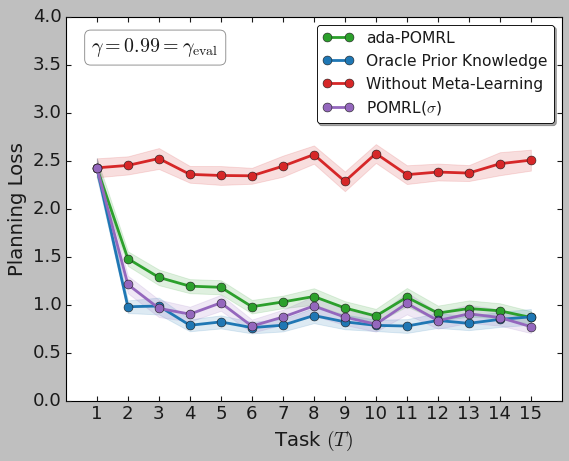

In [ ]:
# Planning Loss - Fixed Gamma Value 
gamma_chosen =  0.99
figomrl_loss_fixedgamma = plotloss_fixedgamma(avg_loss_per_round_dict, 
                                                    avg_err_per_round_dict,
                                                    gammas, num_tasks,
                                                    gamma_chosen=gamma_chosen)